## Table of Contents

1. [Exploring the dataset](#explore)
2. [Preparing the data](#prep)
3. [Identifying response variable](#response)
4. [Normalizing the data](#norm)
5. [Shuffle and split data](#shuffle)
6. [Evaluating model performance](#performance)
    - [Benchmark Model](#benchmark)
    - [AdaBoost Regressor](#ada)
    - [Extra Trees Regressor](#extra)
    - [Gradient Boosting Regressor](#gbr)
    - [Light GBM](#lgb)
    - [Random Forest Regressor](#rfr)
7. [Comparing models](#compare)
8. [Hyperparamter Tuning](#hyper)
    - [Light GBM](#hyper_lgb)
    - [Gradient Boosting Regressor](#hyper_gbr)
9. [Analysis of final model](#analysis)
    - [Cross validation](#cv)
    - [Graduation rates](#grad)
    - [Retention rates](#ret)    
10. [Conclusion](#conclusion)
11. [References](#refs)

<a id='explore'></a>
## 1. Exploring the dataset

In [1]:
# imports
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor,\
GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

# pretty display for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-white')

# hide warnings
import warnings
warnings.filterwarnings("ignore")

# load the dataset
df  = pd.read_csv("data/data.csv")

# display the first record
df.head(1)

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,INSTURL,NPCURL,HCM2,PREDDEG,...,RET_PTL4,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GT_25K_P6,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP,RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,www.aamu.edu/,www2.aamu.edu/scripts/netpricecalc/npcalc.htm,0,3,...,NaN,0.8159,0.0877,29900,0.453,35000,361.891446885773,0.2458495231,NaN,0.3303


In [2]:
df.shape

(7593, 123)

Check for duplicates:

In [3]:
df.duplicated().any()

False

There are no duplicate entries in this data.

Total number of records:

In [4]:
df.shape[0]

7593

Name and explanation of variables are included in _metadata.xlsx_. But let us see a brief explanation of each feature:

**UNITID**: Unit ID for institution

**OPEID**: 8-digit OPEID ID for institution

**OPEID6**: 6-digit OPEID for institution

**INSTNM**: Institution name

**CITY**: city

**STABBR**: State postcode

**INSTURL**: URL for instution's homepage

**NPCURL**: URL for institution's net price calculator

**HCM2**: Schools that are on Heightened Cash Monitoring 2 by the Department of Education

**PREDDEG**: Predominant undergraduate degree awarded. Can take 5 values:

    1. Not classified
    2. Predominantly certificate-degree granting
    3. Predominantly associate's-degree granting
    4. Predominantly bachelor's-degree granting
    5. Entirely graduate-degree granting

**HIGHDEG**: Highest degree awarded. Can take 5 values:

    1. Non-degree-granting
    2. Certificate degree
    3. Associate degree
    4. Bachelor's degree
    5. Graduate degree

**CONTROL**: Control of institution. Can take 3 values:

    1. Public
    2. Private non-profit
    3. Private for-profit

**LOCALE**: Locale of institution. Can take 12 values:

    1. City: Large (population of 250,000 or more)
    2. City: Midsize (population of at least 100,000 but less than 250,000)
    3. City: Small (population less than 100,000)
    4. Suburb: Large (outside principal city, in urbanized area with population of 250,000 or more)
    5. Suburb: Midsize (outside principal city, in urbanized area with population of at least 100,000 but less than 250,000)
    6. Suburb: Small (outside principal city, in urbanized area with population less than 100,000)
    7. Town: Fringe (in urban cluster up to 10 miles from an urbanized area)
    8. Town: Distant (in urban cluster more than 10 miles and up to 35 miles from an urbanized area)
    9. Town: Remote (in urban cluster more than 35 miles from an urbanized area)
    10. Rural: Fringe (rural territory up to 5 miles from an urbanized area or up to 2.5 miles from an urban cluster)
    11. Rural: Distant (rural territory more than 5 miles but up to 25 miles from an urbanized area or more than 2.5 and up to 10 miles from an urban cluster)
    12. Rural: Remote (rural territory more than 25 miles from an urbanized area and more than 10 miles from an urban cluster)

**HBCU**: Flag for historically Black College and University.

**PBI**: Flag for predominantly black institution.

**ANNHI**: Flag for Alaska Native Native Hawaiian serving institution.

**TRIBAL**: Flag for tribal college and university

**AANAPII**: Flag for Asian American Native American Pacific Islander-serving institution

**HSI**: Flag for Hispanic-serving institution

**NANTI**: Flag for Native American non-tribal institution

**MENONLY**: Flag for men-only college

**WOMENONLY**: Flag for women-only college

**RELAFFIL**: Religious affiliation of the institution. It can take 65 values:

    1. Not reported
    2. Not applicable
    3. American Evangelical Lutheran Church
    4. African Methodist Episcopal Zion Church
    5. Assemblies of God Church
    6. Brethren Church
    7. Roman Catholic
    8. Wisconsin Evangelical Lutheran Synod
    9. Christ and Missionary Alliance Church
    10. Christian Reformed Church
    11. Evangelical Congregational Church
    12. Evangelical Covenant Church of America
    13. Evangelical Free Church of America
    14. Evangelical Lutheran Church
    15. International United Pentecostal Church
    16. Free Will Baptist Church
    17. Interdenominational
    18. Mennonite Brethren Church
    19. Moravian Church
    20. North American Baptist
    21. Pentecostal Holiness Church
    22. Christian Churches and Churches of Christ
    23. Reformed Church in America
    24. Episcopal Church, Reformed
    25. African Methodist Episcopal
    26. American Baptist
    27. American Lutheran
    28. Baptist
    29. Christian Methodist Episcopal
    30. Church of God
    31. Church of Brethren
    32. Church of the Nazarene
    33. Cumberland Presbyterian
    34. Christian Church (Disciples of Christ)
    35. Free Methodist
    36. Friends
    37. Presbyterian Church (USA)
    38. Lutheran Church in America
    39. Lutheran Church - Missouri Synod
    40. Mennonite Church
    41. United Methodist
    42. Protestant Episcopal
    43. Churches of Christ
    44. Southern Baptist
    45. United Church of Christ
    46. Protestant, not specified
    47. Multiple Protestant Denomination
    48. Other Protestant
    49. Jewish
    50. Reformed Presbyterian Church
    51. United Brethren Church
    52. Missionary Church Inc
    53. Undenominational
    54. Wesleyan
    55. Greek Orthodox
    56. Russian Orthodox
    57. Unitarian Universalist
    58. Latter Day Saints (Mormon Church)
    59. Seventh Day Adventists
    60. The Presbyterian Church in America
    61. Other (none of the above)
    62. Original Free Will Baptist
    63. Ecumenical Christian
    64. Evangelical Christian
    65. Presbyterian


**SATVR25**: 25th percentile of SAT scores at the institution (critical reading)

**SATVR75**: 75th percentile of SAT scores at the institution (critical reading)

**SATMT25**: 25th percentile of SAT scores at the institution (math)

**SATMT75**: 75th percentile of SAT scores at the institution (math)

**SATWR25**: 25th percentile of SAT scores at the institution (writing)

**SATWR75**: 75th percentile of SAT scores at the institution (writing)

**SATVRMID**: Midpoint of SAT scores at the institution (critical reading)

**SATMTMID**: Midpoint of SAT scores at the institution (math)

**SATWRMID**: Midpoint of SAT scores at the institution (writing)

**ACTCM25**: 25th percentile of the ACT cumulative score

**ACTCM75**: 75th percentile of the ACT cumulative score

**ACTEN25**: 25th percentile of the ACT English score

**ACTEN75**: 75th percentile of the ACT English score

**ACTMT25**: 25th percentile of the ACT math score

**ACTMT75**: 75th percentile of the ACT math score

**ACTWR25**: 25th percentile of the ACT writing score

**ACTWR75**: 75th percentile of the ACT writing score

**ACTCMMID**: Midpoint of the ACT cumulative score

**ACTENMID**: Midpoint of the ACT English score

**ACTMTMID**: Midpoint of the ACT math score

**ACTWRMID**: Midpoint of the ACT writing score

**SAT_AVG**: Average SAT equivalent score of students admitted

**SAT_AVG_ALL**:Average SAT equivalent score of students admitted for all campuses rolled up to the 6-digit OPE ID

**PCIP01**: Percentage of degrees awarded in Agriculture, Agriculture Operations, And Related Sciences.

**PCIP03**: Percentage of degrees awarded in Natural Resources And Conservation.

**PCIP04**: Percentage of degrees awarded in Architecture And Related Services.

**PCIP05**: Percentage of degrees awarded in Area, Ethnic, Cultural, Gender, And Group Studies.

**PCIP09**: Percentage of degrees awarded in Communication, Journalism, And Related Programs.

**PCIP10**: Percentage of degrees awarded in Communications Technologies/Technicians And Support Services.

**PCIP11**: Percentage of degrees awarded in Computer And Information Sciences And Support Services.

**PCIP12**: Percentage of degrees awarded in Personal And Culinary Services.

**PCIP13**: Percentage of degrees awarded in Education.

**PCIP14**: Percentage of degrees awarded in Engineering.

**PCIP15**: Percentage of degrees awarded in Engineering Technologies And Engineering-Related Fields.

**PCIP16**: Percentage of degrees awarded in Foreign Languages, Literatures, And Linguistics.

**PCIP19**: Percentage of degrees awarded in Family And Consumer Sciences/Human Sciences.

**PCIP22**: Percentage of degrees awarded in Legal Professions And Studies.

**PCIP23**: Percentage of degrees awarded in English Language And Literature/Letters.

**PCIP24**: Percentage of degrees awarded in Liberal Arts And Sciences, General Studies And Humanities.

**PCIP25**: Percentage of degrees awarded in Library Science.

**PCIP26**: Percentage of degrees awarded in Biological And Biomedical Sciences.

**PCIP27**: Percentage of degrees awarded in Mathematics And Statistics.

**PCIP29**: Percentage of degrees awarded in Military Technologies And Applied Sciences.

**PCIP30**: Percentage of degrees awarded in Multi/Interdisciplinary Studies.

**PCIP31**: Percentage of degrees awarded in Parks, Recreation, Leisure, And Fitness Studies.

**PCIP38**: Percentage of degrees awarded in Philosophy And Religious Studies.

**PCIP39**: Percentage of degrees awarded in Theology And Religious Vocations.

**PCIP40**: Percentage of degrees awarded in Physical Sciences.

**PCIP41**: Percentage of degrees awarded in Science Technologies/Technicians.

**PCIP42**: Percentage of degrees awarded in Psychology.

**PCIP43**: Percentage of degrees awarded in Homeland Security, Law Enforcement, Firefighting And Related Protective 
Services.

**PCIP44**: Percentage of degrees awarded in Public Administration And Social Service Professions.

**PCIP45**: Percentage of degrees awarded in Social Sciences.

**PCIP46**: Percentage of degrees awarded in Construction Trades.

**PCIP47**: Percentage of degrees awarded in Mechanic And Repair Technologies/Technicians.

**PCIP48**: Percentage of degrees awarded in Precision Production.

**PCIP49**: Percentage of degrees awarded in Transportation And Materials Moving.

**PCIP50**: Percentage of degrees awarded in Visual And Performing Arts.

**PCIP51**: Percentage of degrees awarded in Health Professions And Related Programs.

**PCIP52**: Percentage of degrees awarded in Business, Management, Marketing, And Related Support Services.

**PCIP54**: Percentage of degrees awarded in History.

**DISTANCEONLY**: Flag for distance-education-only education

**UGDS**: Enrollment of undergraduate certificate/degree-seeking students

**UGDS_WHITE**: Total share of enrollment of undergraduate degree-seeking students who are white

**UGDS_BLACK**: Total share of enrollment of undergraduate degree-seeking students who are black

**UGDS_HISP**: Total share of enrollment of undergraduate degree-seeking students who are Hispanic

**UGDS_ASIAN**: Total share of enrollment of undergraduate degree-seeking students who are Asian

**UGDS_AIAN**: Total share of enrollment of undergraduate degree-seeking students who are American Indian/Alaska Native

**UGDS_NHPI**: Total share of enrollment of undergraduate degree-seeking students who are Native Hawaiian/Pacific 
Islander

**UGDS_2MOR**: Total share of enrollment of undergraduate degree-seeking students who are two or more races

**UGDS_NRA**: Total share of enrollment of undergraduate degree-seeking students who are non-resident aliens

**UGDS_UNKN**: Total share of enrollment of undergraduate degree-seeking students whose race is unknown

**PPTUG_EF**: Share of undergraduate, degree-/certificate-seeking students who are part-time 

**CURROPER**: Flag for currently operating institution, 0=closed, 1=operating

**NPT4_PUB**: Average net price for Title IV institutions (public institutions)

**NPT4_PRIV**: Average net price for Title IV institutions (private for-profit and nonprofit institutions)

**NPT41_PUB**: Average net price for \$0-$30,000 family income (public institutions)

**NPT42_PUB**: Average net price for \$30,001-$48,000 family income (public institutions)

**NPT43_PUB**: Average net price for \$48,001-$75,000 family income (public institutions)

**NPT44_PUB**: Average net price for \$75,001-$110,000 family income (public institutions)

**NPT45_PUB**: Average net price for \$110,000+ family income (public institutions)

**NPT41_PRIV**: Average net price for \$0-$30,000 family income (private for-profit and nonprofit institutions)

**NPT42_PRIV**: Average net price for \$30,001-$48,000 family income (private for-profit and nonprofit institutions)

**NPT43_PRIV**: Average net price for \$48,001-$75,000 family income (private for-profit and nonprofit institutions)

**NPT44_PRIV**: Average net price for \$75,001-$110,000 family income (private for-profit and nonprofit institutions)

**NPT45_PRIV**: Average net price for \$110,000+ family income (private for-profit and nonprofit institutions)

**PCTPELL**: Percentage of undergraduates who receive a Pell Grant

**PCTFLOAN**: Percent of all undergraduate students receiving a federal student loan

**UG25ABV**: Percentage of undergraduates aged 25 and above

**MD_EARN_WNE_P10**: Median earnings of students working and not enrolled 10 years after entry

**GT_25K_P6**: Share of students earning over $25,000/year (threshold earnings) 6 years after entry

**GRAD_DEBT_MDN_SUPP**: Median debt of completers, suppressed for n=30

**GRAD_DEBT_MDN10YR_SUPP**: Median debt of completers expressed in 10-year monthly payments, suppressed for n=30

**RPY_3YR_RT_SUPP**: 3-year repayment rate, suppressed for n=30

<a id ='prep'></a>

## 2. Preparing the data

Let us check the quality of data. But before doing this, let us remove the features in which we are not interested.

## Feature Selection

In [5]:
df[["OPEID", "OPEID6", "UNITID"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Data columns (total 3 columns):
OPEID     7593 non-null int64
OPEID6    7593 non-null int64
UNITID    7593 non-null int64
dtypes: int64(3)
memory usage: 178.0 KB


In [6]:
df[['OPEID', 'OPEID6', 'UNITID']].nunique()

OPEID     7563
OPEID6    5599
UNITID    7593
dtype: int64

Checking for duplicates in these columns:

In [7]:
for col in ['OPEID', 'OPEID6', 'UNITID']:
    print("Number of duplicates in {} is {}".format(col,df[col].duplicated().sum()))#[df['OPEID'].duplicated().sum()

Number of duplicates in OPEID is 30
Number of duplicates in OPEID6 is 1994
Number of duplicates in UNITID is 0


I want to use `UNITID` as identifiers for every row.

In [8]:
# removing irrelevant identifiers
df.drop(["OPEID", "OPEID6"],
       axis = 1,
       inplace = True)

In [9]:
for col in df.columns[21:44]:
    df[col].fillna(df[col].median(), inplace = True)

For SAT and ACT scores we have 25 percentile, 75 percentile and mid-point values. Let us see the distribution of scores.

In [10]:
#df.columns[21:44]
# replacing null values with respective median for SAT and ACT scores
for col in df.columns[21:44]:
    df[col].fillna(df[col].median(), inplace = True)

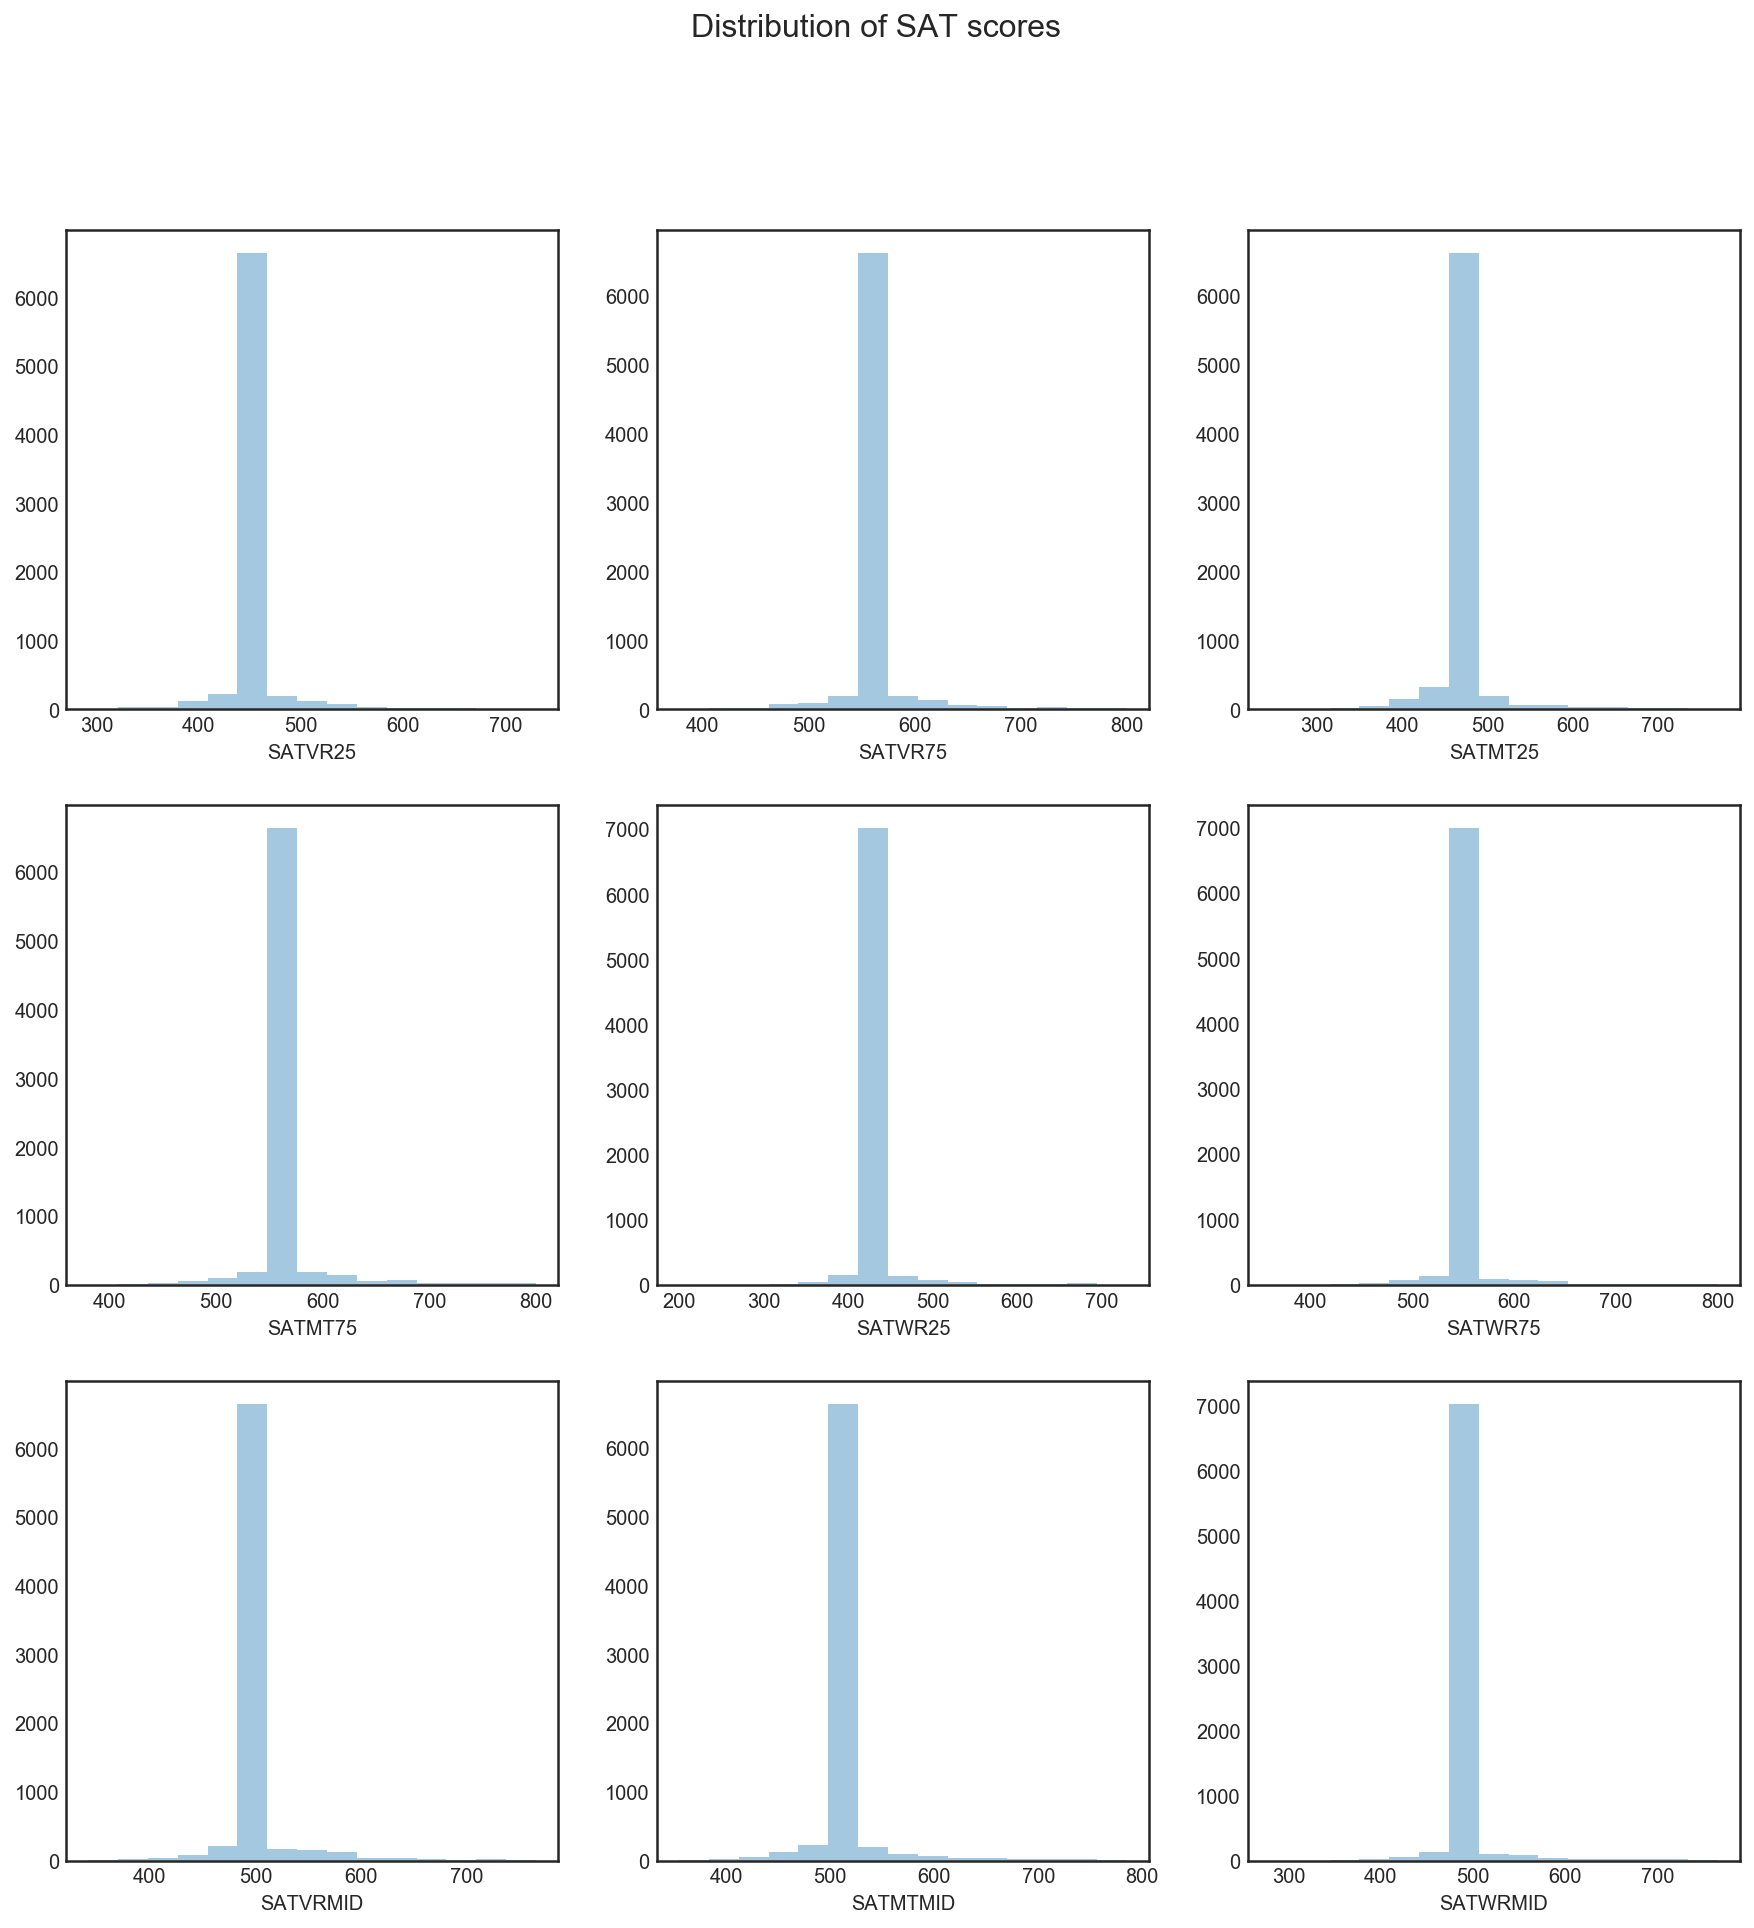

In [11]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15,15))
f.suptitle("Distribution of SAT scores", fontsize=16)
sns.distplot(df['SATVR25'], ax=ax1, kde=False, bins=15)
sns.distplot(df['SATVR75'], ax=ax2, kde=False, bins=15)
sns.distplot(df['SATMT25'], ax=ax3, kde=False, bins=15)
sns.distplot(df['SATMT75'], ax=ax4, kde=False, bins=15)
sns.distplot(df['SATWR25'], ax=ax5, kde=False, bins=15)
sns.distplot(df['SATWR75'], ax=ax6, kde=False, bins=15)
sns.distplot(df['SATVRMID'], ax=ax7, kde=False, bins=15)
sns.distplot(df['SATMTMID'], ax=ax8, kde=False, bins=15)
sns.distplot(df['SATWRMID'], ax=ax9, kde=False, bins=15)
plt.savefig("./img/sat.png")

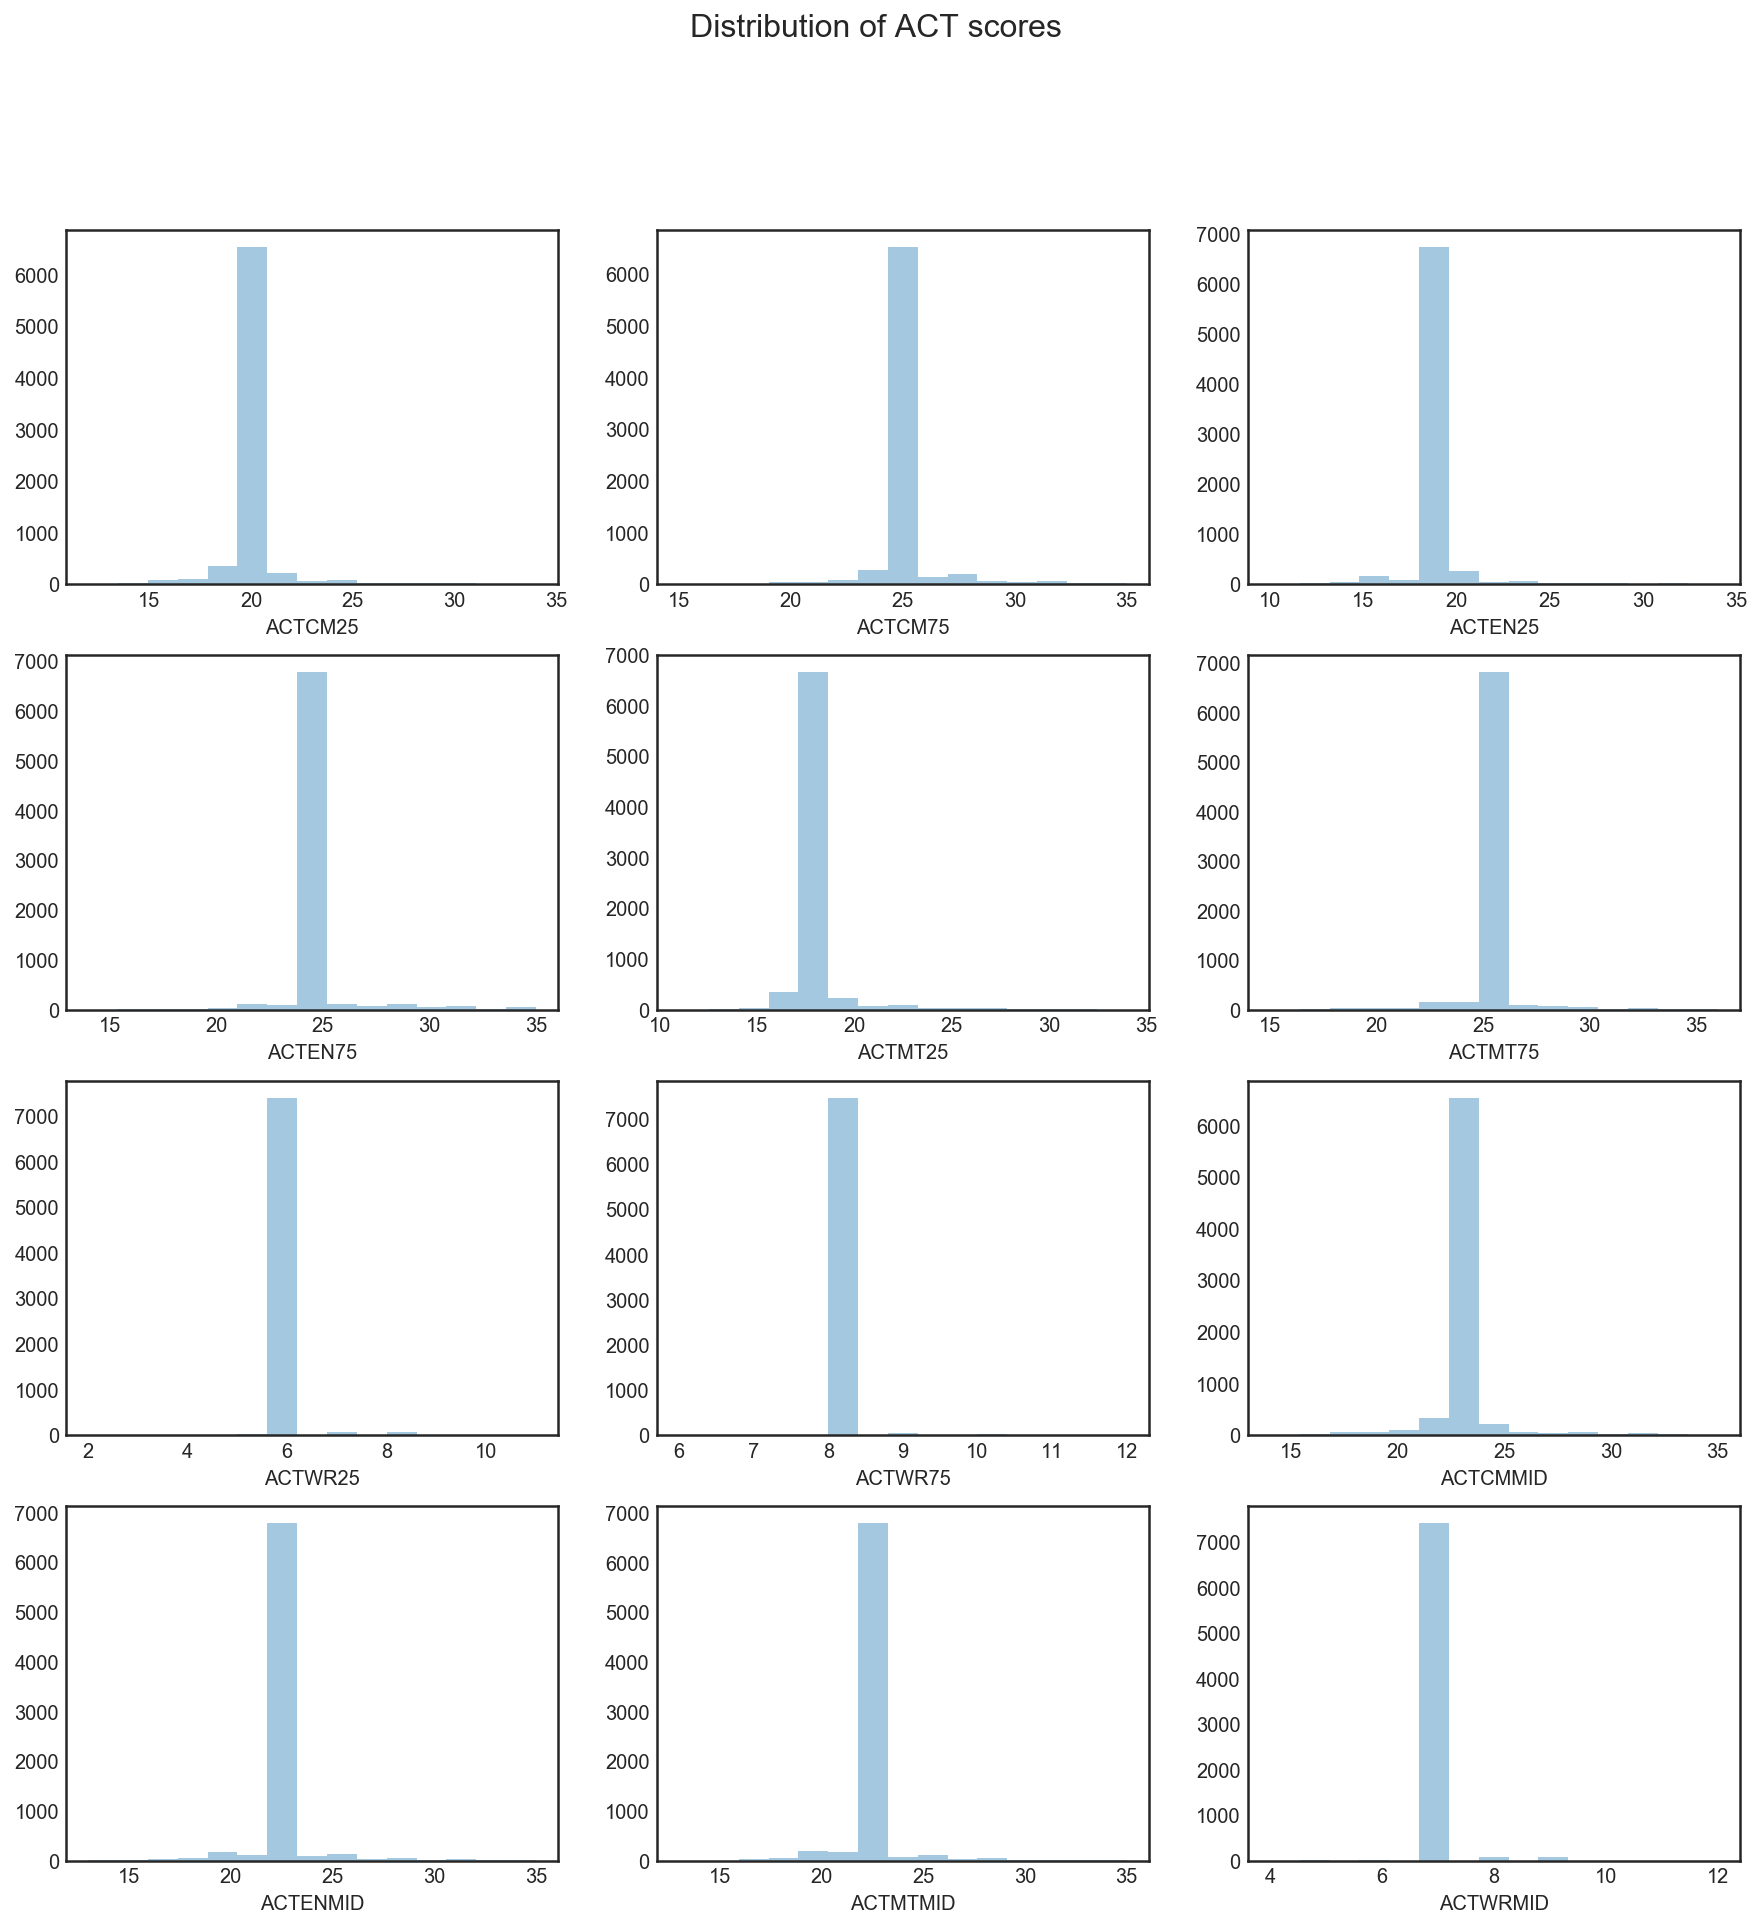

In [12]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), ( ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(15,15))
f.suptitle("Distribution of ACT scores", fontsize=16)
sns.distplot(df['ACTCM25'], ax=ax1, kde=False, bins=15)
sns.distplot(df['ACTCM75'], ax=ax2, kde=False, bins=15)
sns.distplot(df['ACTEN25'], ax=ax3, kde=False, bins=15)
sns.distplot(df['ACTEN75'], ax=ax4, kde=False, bins=15)
sns.distplot(df['ACTMT25'], ax=ax5, kde=False, bins=15)
sns.distplot(df['ACTMT75'], ax=ax6, kde=False, bins=15)
sns.distplot(df['ACTWR25'], ax=ax7, kde=False, bins=15)
sns.distplot(df['ACTWR75'], ax=ax8, kde=False, bins=15)
sns.distplot(df['ACTCMMID'], ax=ax9, kde=False, bins=15)
sns.distplot(df['ACTENMID'], ax=ax10, kde=False, bins=15)
sns.distplot(df['ACTMTMID'], ax=ax11, kde=False, bins=15)
sns.distplot(df['ACTWRMID'], ax=ax12, kde=False, bins=15)
plt.savefig("./img/act.png")

Since the distribution of 25 percentile and 75 percentile is same as that of mid-point values, we can ignore 25 and 75 percentile values. Even the distribution of mid-point values is also not normal, but in order to consider the transcripts of students as a factor and to avoid curse of dimensionality we are keeping mid-point values and ignoring the 25 and 75 percentile values.

In [13]:
# removing 25 and 75 percentile marks
df.drop(['SATVR25', 'SATVR75',
        'SATMT25', 'SATMT75',
        'SATWR25', 'SATWR75',
        'ACTCM25', 'ACTCM75',
        'ACTEN25', 'ACTEN75',
        'ACTMT25', 'ACTMT75',
        'ACTWR25', 'ACTWR75'],
       axis = 1,
       inplace = True)

We have two columns for SAT Average: `SAT_AVG` and `SAT_AVG_ALL`. Since we have removed `OPEID` column, we will be using `SAT_AVG` column because it provides overall stats, rather than averages based on `OPEID`.

In [14]:
# removing SAT_AVG_ALL
df.drop(['SAT_AVG_ALL'],
       axis = 1,
       inplace = True)

We have average net price for public and private institutions. We will remove the average price based on different family income levels and use the overall average net price for public and private institutions. We are removing columns related to family income levels because we don't think that family income is a **university level factor**. This is a factor based on **student level**.

In [15]:
# removing prices based on family income
df.drop(['NPT41_PUB', 'NPT42_PUB', 'NPT43_PUB', 'NPT44_PUB', 'NPT45_PUB',
         'NPT41_PRIV', 'NPT42_PRIV', 'NPT43_PRIV', 'NPT44_PRIV', 'NPT45_PRIV'],
       axis = 1,
       inplace = True)

Now let us see other variables which have many distinct values and need to be removed.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Data columns (total 96 columns):
UNITID                    7593 non-null int64
INSTNM                    7593 non-null object
CITY                      7593 non-null object
STABBR                    7593 non-null object
INSTURL                   7573 non-null object
NPCURL                    7075 non-null object
HCM2                      7593 non-null int64
PREDDEG                   7593 non-null int64
HIGHDEG                   7593 non-null int64
CONTROL                   7593 non-null int64
LOCALE                    7147 non-null float64
HBCU                      7147 non-null float64
PBI                       7147 non-null float64
ANNHI                     7147 non-null float64
TRIBAL                    7147 non-null float64
AANAPII                   7147 non-null float64
HSI                       7147 non-null float64
NANTI                     7147 non-null float64
MENONLY                   7147 non-null floa

Now I am removing the **Categorical Columns ( dtype object )** which have many levels.

In [17]:
df.drop(['INSTNM', "CITY", "INSTURL", "NPCURL", "STABBR", "RELAFFIL"],
       axis = 1,
       inplace = True)

We are keeping categorical columns which have less than 10 levels.

`INSTNM`, `INSTURL` & `NPCURL` are identifiers for colleges in offline or online media and are not university level factors which affect education's status.

`STABBR`, `CITY` & `RELAFFIL` columns have been removed because they had too many levels to account for.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Data columns (total 90 columns):
UNITID                    7593 non-null int64
HCM2                      7593 non-null int64
PREDDEG                   7593 non-null int64
HIGHDEG                   7593 non-null int64
CONTROL                   7593 non-null int64
LOCALE                    7147 non-null float64
HBCU                      7147 non-null float64
PBI                       7147 non-null float64
ANNHI                     7147 non-null float64
TRIBAL                    7147 non-null float64
AANAPII                   7147 non-null float64
HSI                       7147 non-null float64
NANTI                     7147 non-null float64
MENONLY                   7147 non-null float64
WOMENONLY                 7147 non-null float64
SATVRMID                  7593 non-null float64
SATMTMID                  7593 non-null float64
SATWRMID                  7593 non-null float64
ACTCMMID                  7593 non-null

Calling `.info()` method shows data type _"object"_ for last few columns. This is because some values in these columns are "**PrivacySuppressed**".

Checking for null values:

In [19]:
df.loc[:,df.isnull().any()].head()

,LOCALE,HBCU,PBI,ANNHI,TRIBAL,AANAPII,HSI,NANTI,MENONLY,WOMENONLY,...,RET_PTL4,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GT_25K_P6,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP,RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP
0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.8159,0.0877,29900,0.453,35000,361.891446885773,0.2458495231,NaN,0.3303
1,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.5218,0.2363,40200,0.669,21500,222.304745944118,0.5199110572,NaN,0.5504
2,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.8781,0.8571,40100,0.658,23000,237.814379382079,0.2331002331,NaN,PrivacySuppressed
3,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.4589,0.2255,45600,0.685,23500,242.984257194733,0.5490029699,NaN,0.4776
4,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.7692,0.0974,26700,0.393,32091,331.813097771753,0.1963538553,NaN,0.2663


**IMPORTANT**

There are two types of invalid entries here. First is the `NaN` entry and another is `PrivacySuppressed`.

We will first convert `PrivacySuppressed` to null value and then replace all the null values accordingly.

In [20]:
# convert "PrivacySuppressed" to NaN
df.replace('PrivacySuppressed', np.nan, inplace = True)

In [21]:
df.head()

,UNITID,HCM2,PREDDEG,HIGHDEG,CONTROL,LOCALE,HBCU,PBI,ANNHI,TRIBAL,...,RET_PTL4,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GT_25K_P6,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP,RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP
0,100654,0,3,4,1,12.0,1.0,0.0,0.0,0.0,...,NaN,0.8159,0.0877,29900,0.453,35000,361.891446885773,0.2458495231,NaN,0.3303
1,100663,0,3,4,1,12.0,0.0,0.0,0.0,0.0,...,NaN,0.5218,0.2363,40200,0.669,21500,222.304745944118,0.5199110572,NaN,0.5504
2,100690,0,3,4,2,12.0,0.0,1.0,0.0,0.0,...,NaN,0.8781,0.8571,40100,0.658,23000,237.814379382079,0.2331002331,NaN,NaN
3,100706,0,3,4,1,12.0,0.0,0.0,0.0,0.0,...,NaN,0.4589,0.2255,45600,0.685,23500,242.984257194733,0.5490029699,NaN,0.4776
4,100724,0,3,4,1,12.0,1.0,0.0,0.0,0.0,...,NaN,0.7692,0.0974,26700,0.393,32091,331.813097771753,0.1963538553,NaN,0.2663


In [22]:
df[df.columns[-7:]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Data columns (total 7 columns):
MD_EARN_WNE_P10           5682 non-null object
GT_25K_P6                 5840 non-null object
GRAD_DEBT_MDN_SUPP        6024 non-null object
GRAD_DEBT_MDN10YR_SUPP    6024 non-null object
RPY_3YR_RT_SUPP           6171 non-null object
C150_L4_POOLED_SUPP       3718 non-null object
C150_4_POOLED_SUPP        2371 non-null object
dtypes: object(7)
memory usage: 415.3+ KB


After converting `PrivacySuppressed` to `NaN`, pandas still treats them as _object_ data type. Below is a table showing correct data type of these columns (from _data/metadata.xlsx_):

| Column| Data type |
|------|------|
|MD_EARN_WNE_P10| integer|
|GT_25K_P6|float|
|GRAD_DEBT_MDN_SUPP|float|
|GRAD_DEBT_MDN10YR_SUPP|float|
|RPY_3YR_RT_SUPP|float|
|C150_L4_POOLED_SUPP|float|
|C150_4_POOLED_SUPP|float|

Converting `MD_EARN_WNE_P10` to _integer_ data type: 

In [23]:
# Running the below code cell will throw an error because NaN cannot be converted to integer

In [24]:
#df['MD_EARN_WNE_P10'] = df['MD_EARN_WNE_P10'].astype(int)

So first we will convert `MD_EARN_WNE_P10` to _float_ data type.

In [25]:
# creating a list of the last few columns which have data type string
str_cols = df[df.columns[-7:]].columns

In [26]:
# converting columns' data type from string to float
for col in str_cols:
    df[col] = df[col].astype(float)

In [27]:
# verifying
df[df.columns[-7:]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Data columns (total 7 columns):
MD_EARN_WNE_P10           5682 non-null float64
GT_25K_P6                 5840 non-null float64
GRAD_DEBT_MDN_SUPP        6024 non-null float64
GRAD_DEBT_MDN10YR_SUPP    6024 non-null float64
RPY_3YR_RT_SUPP           6171 non-null float64
C150_L4_POOLED_SUPP       3718 non-null float64
C150_4_POOLED_SUPP        2371 non-null float64
dtypes: float64(7)
memory usage: 415.3 KB


> **IMPORTANT**

    But before applying median imputation, we need to check for some other categorical columns which might be important for analysis. There are some categorical levels which cannot be ignored while building the model. Those columns are:
    1. PREDDEG
    2. HIGHDEG
    3. CONTROL
    4. LOCALE(contains 12 levels but we will reduce them to 4 levels)

In [28]:
# f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
# sns.distplot(df['PREDDEG'], ax=ax1, kde=False)
# sns.distplot(df['HIGHDEG'], ax=ax2, kde=False)
# sns.distplot(df['CONTROL'], ax=ax3, kde=False)
# sns.distplot(df[(df['LOCALE'] != -3) & (df['LOCALE'].notnull())]['LOCALE'], ax=ax4, kde=False) #excluding invalid entires
# plt.savefig("./img/categorical_variables.png")

Running above cell will throw an error because `LOCALE` column contains some invalid entries like NaN and -3.

In order to facilitate our visualisation of `LOCALE` column ,we will exclude NaNs and -3.

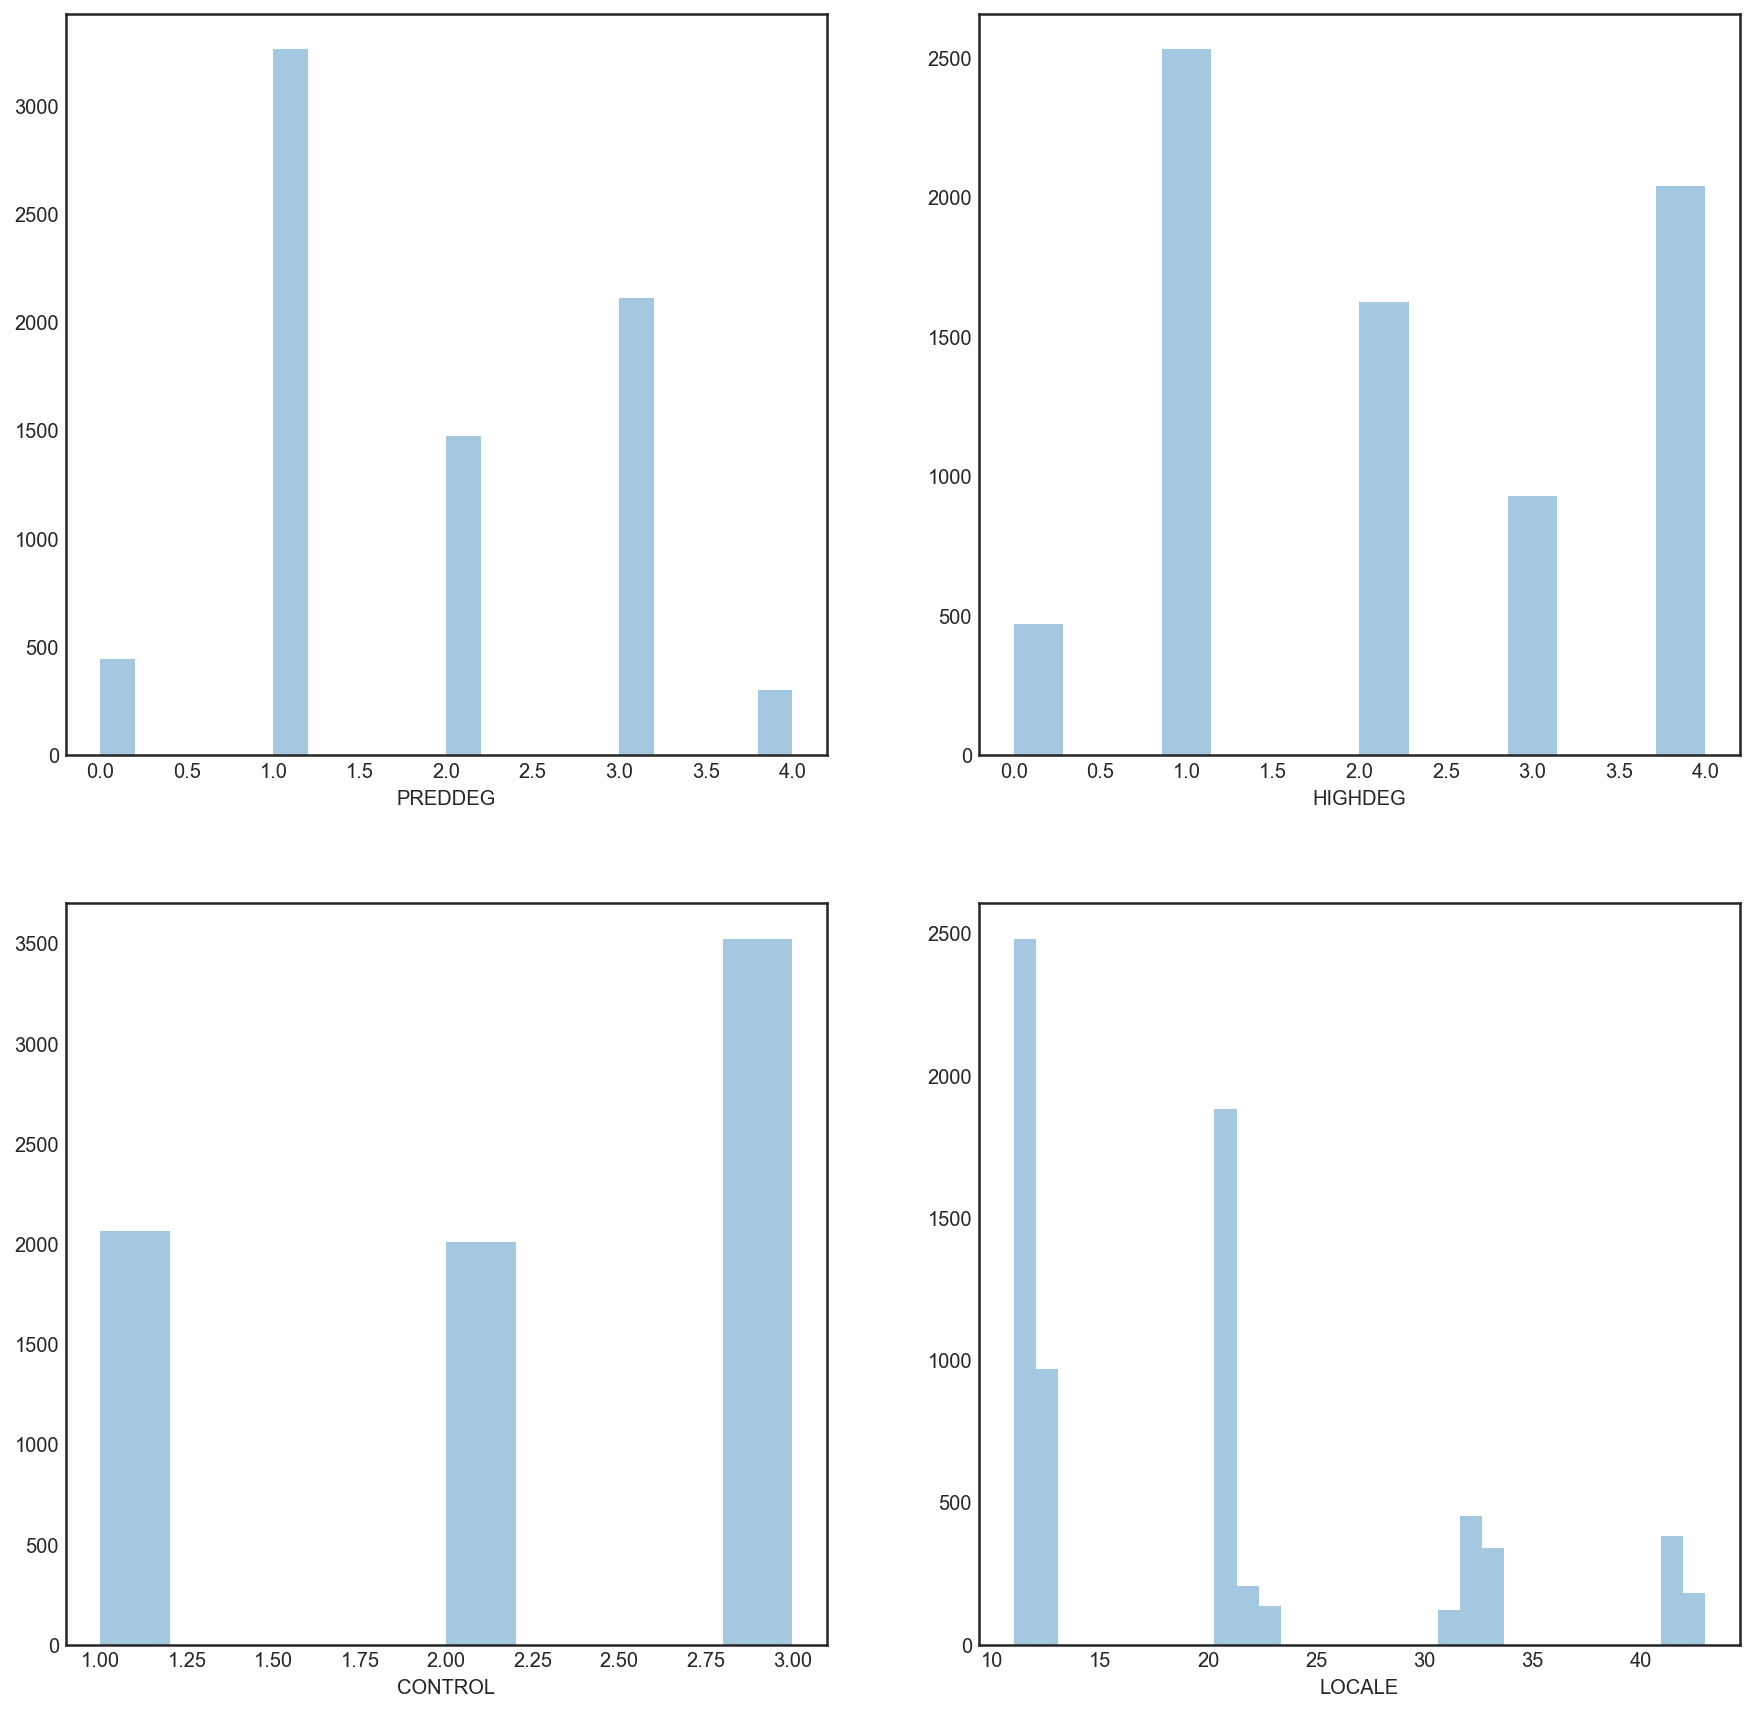

In [29]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
sns.distplot(df['PREDDEG'], ax=ax1, kde=False)
sns.distplot(df['HIGHDEG'], ax=ax2, kde=False)
sns.distplot(df['CONTROL'], ax=ax3, kde=False)
sns.distplot(df[(df['LOCALE'] != -3) & (df['LOCALE'].notnull())]['LOCALE'], ax=ax4, kde=False) #excluding invalid entires
plt.savefig("./img/categorical_variables.png")

Now we will create dummy variables for these 4 categorical columns:

In [30]:
# for PREDDEG column
df[['pred_deg.not_classified', 'pred_deg.certificate_degree', 'pred_deg.associates_degree',
    'pred_deg.bachelors_degree', 'pred_deg.entire_graduate']] = pd.get_dummies(df['PREDDEG'])



# for CONTROL column
df[['Public', 'Private nonprofit', 'Private for-profit']] = pd.get_dummies(df.CONTROL)



# for HIGHDEG column
df[['Non-degree-granting', 'Certificate degree',
    'Associate Degree', 'Bachelors Degree', 'Graduate Degree']] = pd.get_dummies(df.HIGHDEG)



# for LOCALE column
loc_new = []

for loc in df.LOCALE:
    if loc in [11, 12, 13]:
        loc_new.append('CITY')
    elif loc in [21, 22, 23]:
        loc_new.append('SUBURB')
    elif loc in [31, 32, 33]:
        loc_new.append('TOWN')
    elif loc in [41, 42, 43]:
        loc_new.append('RURAL')
    else:
        loc_new.append(np.nan)

# replacing the old column        
df['LOCALE'] = loc_new

# creating dummy variable
df[['CITY', 'RURAL', 'SUBURB', 'TOWN']] = pd.get_dummies(df.LOCALE)

# removing the original columns
df.drop(['PREDDEG', 'CONTROL', 'HIGHDEG', 'LOCALE'], axis = 1, inplace = True)

In [31]:
# replacing null values in numerical columns with their respective median
for col in df[df.columns]: 
    df[col].fillna(value = df[col].median(),
                  inplace = True)

The column names are not user-friendly. I am renaming them for easy readability. The new names are **developer friendly** names taken from _data/metadata.xlsx_ file.

In [32]:
df.rename(columns = {'HCM2':'under_investigation',
           'HBCU':'minority_serving.historically_black',
           'PBI': 'minority_serving.predominantly_black',
           'ANNHI': 'minority_serving.annh',
           'TRIBAL': 'minority_serving.tribal',
           'AANAPII': 'minority_serving.aanapi',
           'HSI': 'minority_serving.hispanic',
           'NANTI': 'minority_serving.nant',
           'MENONLY': 'men_only',
           'WOMENONLY': 'women_only',
           'SATVRMID': 'sat_scores.midpoint.critical_reading',
           'SATMTMID': 'sat_scores.midpoint.math',
           'SATWRMID': 'sat_scores.midpoint.writing',
           'ACTCMMID': 'act_scores.midpoint.cumulative',
           'ACTENMID': 'act_scores.midpoint.english',
           'ACTMTMID': 'act_scores.midpoint.math',
           'ACTWRMID': 'act_scores.midpoint.writing',
           'SAT_AVG': 'sat_scores.average.overall',
           'PCIP01': 'program_percentage.agriculture',
           'PCIP03': 'program_percentage.resources',
           'PCIP04': 'program_percentage.architecture',
           'PCIP05': 'program_percentage.ethnic_cultural_gender',
           'PCIP09': 'program_percentage.communication',
           'PCIP10': 'program_percentage.communications_technology',
           'PCIP11': 'program_percentage.computer',
           'PCIP12': 'program_percentage.personal_culinary',
           'PCIP13': 'program_percentage.education',
           'PCIP14': 'program_percentage.engineering',
           'PCIP15': 'program_percentage.engineering_technology',
           'PCIP16': 'program_percentage.language',
           'PCIP19': 'program_percentage.family_consumer_service',
           'PCIP22': 'program_percentage.legal',
           'PCIP23': 'program_percentage.english',
           'PCIP24': 'program_percentage.humanities',
           'PCIP25': 'program_percentage.libraries',
           'PCIP26': 'program_percentage.biological',
           'PCIP27': 'program_percentage.mathematics',
           'PCIP29': 'program_percentage.military',
           'PCIP30': 'program_percentage.multidiscipline',
           'PCIP31': 'program_percentage.parks_recreation_fitness',
           'PCIP38': 'program_percentage.philosophy_religious',
           'PCIP39': 'program_percentage.theology_religious_vocation',
           'PCIP40': 'program_percentage.physical_science',
           'PCIP41': 'program_percentage.science_technology',
           'PCIP42': 'program_percentage.psychology',
           'PCIP43': 'program_percentage.security_law_enforcement',
           'PCIP44': 'program_percentage.public_administration_social_service',
           'PCIP45': 'program_percentage.social_science',
           'PCIP46': 'program_percentage.construction',
           'PCIP47': 'program_percentage.mechanic_repair_technology',
           'PCIP48': 'program_percentage.precision_production',
           'PCIP49': 'program_percentage.transportation',
           'PCIP50': 'program_percentage.visual_performing',
           'PCIP51': 'program_percentage.health',
           'PCIP52': 'program_percentage.business_marketing',
           'PCIP54': 'program_percentage.history',
           'DISTANCEONLY': 'online_only',
           'UGDS': 'size',
           'UGDS_WHITE': 'demographics.race_ethnicity.white',
           'UGDS_BLACK': 'demographics.race_ethnicity.black',
           'UGDS_HISP': 'demographics.race_ethnicity.hispanic',
           'UGDS_ASIAN': 'demographics.race_ethnicity.asian',
           'UGDS_AIAN': 'demographics.race_ethnicity.aian',
           'UGDS_NHPI': 'demographics.race_ethnicity.nhpi',
           'UGDS_2MOR': 'demographics.race_ethnicity.two_or_more',
           'UGDS_NRA': 'demographics.race_ethnicity.non_resident_alien',
           'UGDS_UNKN': 'demographics.race_ethnicity.unknown',
           'PPTUG_EF': 'part_time_share',
           'CURROPER': 'operating',
           'NPT4_PUB': 'avg_net_price.public',
           'NPT4_PRIV': 'avg_net_price.private',
           'PCTPELL': 'pell_grant_rate',
           'RET_FT4': 'retention_rate.four_year.full_time',
           'RET_FTL4': 'retention_rate.lt_four_year.full_time',
           'RET_PT4': 'retention_rate.four_year.part_time',
           'RET_PTL4': 'retention_rate.lt_four_year.part_time',
           'PCTFLOAN': 'federal_loan_rate',
           'UG25ABV': 'share_25_older',
           'MD_EARN_WNE_P10': '10_years_after_entry.median',
           'GT_25K_P6': '6_yrs_after_entry.percent_greater_than_25000',
           'GRAD_DEBT_MDN_SUPP': 'median_debt_suppressed.completers.overall',
           'GRAD_DEBT_MDN10YR_SUPP': 'median_debt_suppressed.completers.monthly_payments',
           'RPY_3YR_RT_SUPP': '3_yr_repayment_suppressed.overall',
           'C150_L4_POOLED_SUPP': 'rate_suppressed.lt_four_year_150percent',
           'C150_4_POOLED_SUPP': 'rate_suppressed.four_year'},
         inplace = True)

<a id='response'></a>
## 3. Identifying response variable

Our aim is to determine the relevant university level factors which predict the presence of a strong retention and graduation rates.

1. For graduation rates we have two variables in our data. Let us see the difference between those two:

    1.1. **rate_suppressed.four_year**

    Completion rate for first-time, full-time students at four-year institutions (150% of expected time to completion) , pooled in two-year rolling averages and suppressed for small n size.
    
    1.2. **rate_suppressed.lt_four_year_150percent**
    
    Completion rate for first-time, full-time students at less-than-four-year institutions (150% of expected time to completion) , pooled in two-year rolling averages and suppressed for small n size

    We will be making predictions for 4-year institutions.
    
2. For retention rates we have four variables in our data. Let us see the difference between them:

    2.1. **retention_rate.four_year.full_time**

    First-time, full-time student retention rate at four-year institutions.

    2.2. **retention_rate.lt_four_year.full_time**

    First-time, full-time student retention rate at less-than-four-year institutions.

    2.3. **retention_rate.four_year.part_time**

    First-time, part-time student retention rate at four-year institutions

    2.4. **retention_rate.lt_four_year.part_time**

    First-time, part-time student retention rate at four-year institutions

    
Retention rate is for full-time students and we are making predictions for 4-year institutions. So, our target variable is **retention_rate.four_year.full_time**.
    
    
So there are 2 response variables:
1. **rate_suppressed.four_year**
2. **retention_rate.four_year.full_time**

In [33]:
# subsetting data to get target variables
target = df[['rate_suppressed.four_year', 'retention_rate.four_year.full_time']]

In [34]:
# subsetting data to get features
features = df.drop(['UNITID',
                   'rate_suppressed.four_year', 'rate_suppressed.lt_four_year_150percent',
                   'retention_rate.four_year.full_time', 'retention_rate.lt_four_year.full_time',
                   'retention_rate.four_year.part_time', 'retention_rate.lt_four_year.part_time'],
                  axis = 1)

<a id='norm'></a>
## 4. Normalizing the data

First, let us see the distribution of target labels:

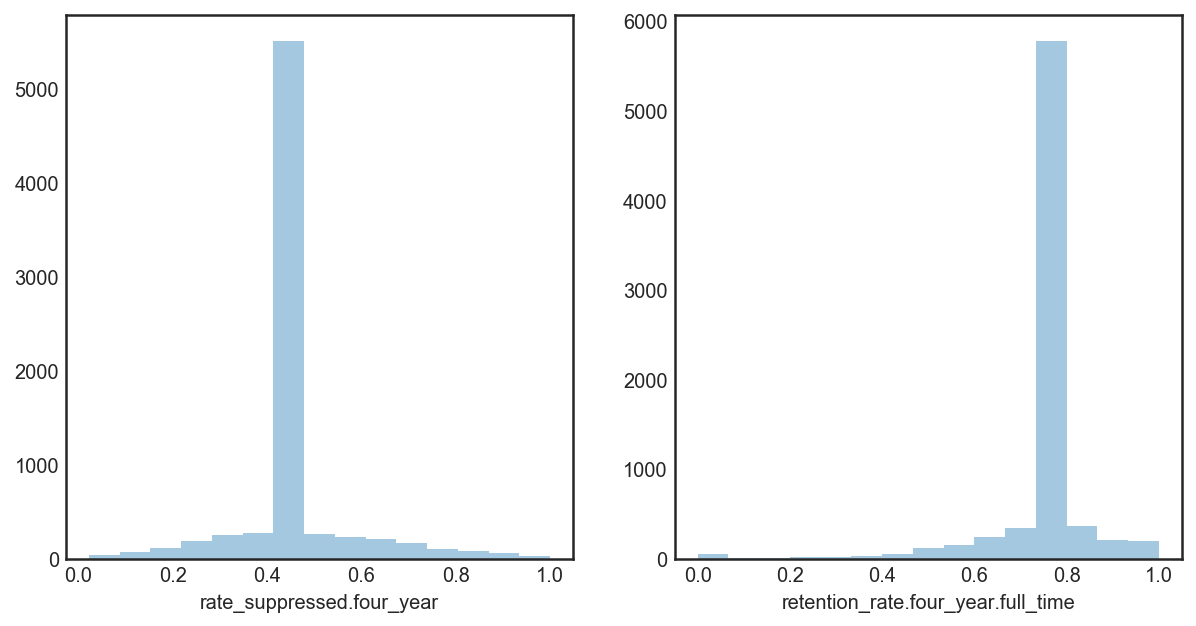

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(df['rate_suppressed.four_year'], ax=ax1, kde=False, bins=15)
sns.distplot(df['retention_rate.four_year.full_time'], ax=ax2, kde=False, bins=15)
plt.savefig("./img/class_labels.png")

In [36]:
df['retention_rate.four_year.full_time'].describe()

count    7593.000000
mean        0.734674
std         0.105929
min         0.000000
25%         0.744200
50%         0.744200
75%         0.744200
max         1.000000
Name: retention_rate.four_year.full_time, dtype: float64

Retention rate has outliers around 0.0. It has to be removed because no US college has zero retention rate. On an average retention rate is 71%<sup>[1]</sup>. This information can be concluded from the summary distribution of retention rate. Mean value is 0.73, i.e. 73%.

In [37]:
print(df[df['retention_rate.four_year.full_time'] == 0].shape[0])

53


In [38]:
100*53/7593

0.6980113262215198

Only 53 out of 7593 observation have outliers in retention rate. That's just 0.7%, so removing them will not result in significant loss of data.

In [39]:
# removing zeroes in retention rates
df = df[df['retention_rate.four_year.full_time'] != 0]

In [40]:
target = df[['rate_suppressed.four_year', 'retention_rate.four_year.full_time']]

In [41]:
features = df.drop(['UNITID',
                   'rate_suppressed.four_year', 'rate_suppressed.lt_four_year_150percent',
                   'retention_rate.four_year.full_time', 'retention_rate.lt_four_year.full_time',
                   'retention_rate.four_year.part_time', 'retention_rate.lt_four_year.part_time'],
                  axis = 1)

Now we will use `StandardScaler` from sklearn to convert this distribution to a normal distribution.

In [42]:
scaler = StandardScaler()

In [43]:
target[target.columns] = scaler.fit_transform(target)

In [44]:
# target 1: graduation rates
grad = target['rate_suppressed.four_year']

In [45]:
# target 2: retention rates
ret = target['retention_rate.four_year.full_time']

In [46]:
features[features.columns] = scaler.fit_transform(features)

4 decimal places for retention rates and 2 decimal places for graduation rates. To learn features and each and every value of target variable we will need a very large dataset. For this problem, we will round off target variables and features to 2 decimal places.

In [47]:
for col in features:
    features[col] = [round(elem, 2) for elem in features[col]]

In [48]:
ret = [round(elem, 2) for elem in ret]

In [49]:
grad = [round(elem, 2) for elem in grad]

<a id='shuffle'></a>
## 5. Shuffle and split data

Now we will perform train-test split.

In [50]:
X_train, X_test, grad_train, grad_test = train_test_split(features,
                                                   grad,
                                                   test_size = 0.2,
                                                   random_state = 0)

In [51]:
X_train, X_test, ret_train, ret_test = train_test_split(features,
                                                        ret,
                                                        test_size = 0.2,
                                                        random_state = 0)

In [52]:
## show the results of the split

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 6032 samples.
Testing set has 1508 samples.


<a id='performance'></a>
## 6. Evaluating model performance

<a id='benchmark'></a>
### 6.1. Benchmark Model:

This is a simple decision tree regression model. We will be using `r2_score` as the evaluation metric. In proposal it was mentioned that linear regression will be used as benchmark but due to some library update in Python3 it is showing error when training.

In [53]:
mod = DecisionTreeRegressor(max_depth = 3, random_state = 0)

In [54]:
# model for graduation rates
mod_grad = mod.fit(X_train, grad_train)
mod_ret = mod.fit(X_train, ret_train)

In [55]:
# model for retention rates
grad_pred = mod_grad.predict(X_test)
ret_pred = mod_ret.predict(X_test)

### Evaluating performance of benchmark model:

In [56]:
print("r2_score for graduation rate is: ", r2_score(grad_test, grad_pred))
print("r2_score for retention rate is: ", r2_score(ret_test, ret_pred))

r2_score for graduation rate is:  0.3135220151679534
r2_score for retention rate is:  0.20537672561310394


Now we will use other regression models from sklearn to beat the performance of decision tree regressor for graduation and retention rates. Scores of benchmark model are:

$$graduation\ rate  = 0.31$$
$$retention\ rate  = 0.20$$

> Tip: The models given below are in alphabetical order.

<a id='ada'></a>
### 6.2. AdaBoost Regressor:

### Training:

In [57]:
mod = AdaBoostRegressor(random_state=0)

### Predicting:

In [58]:
mod_grad = mod.fit(X_train, grad_train)
mod_ret = mod.fit(X_train, ret_train)
grad_pred = mod_grad.predict(X_test)
ret_pred = mod_ret.predict(X_test)

### Evaluating performance:

In [59]:
print("r2_score for graduation rate is: ", r2_score(grad_test, grad_pred))
print("r2_score for retention rate is: ", r2_score(ret_test, ret_pred)) 

r2_score for graduation rate is:  0.11844315688655349
r2_score for retention rate is:  0.1251793487180456


<a id='extra'></a>
### 6.3. Extra Trees Regressor
### Training:

In [60]:
mod = ExtraTreesRegressor(max_depth=2, random_state = 0)

### Predicting:

In [61]:
mod_grad = mod.fit(X_train, grad_train)
mod_ret = mod.fit(X_train, ret_train)
grad_pred = mod_grad.predict(X_test)
ret_pred = mod_ret.predict(X_test)

### Evaluating performance:

In [62]:
print("r2_score for graduation rate is: ", r2_score(grad_test, grad_pred))
print("r2_score for retention rate is: ", r2_score(ret_test, ret_pred))

r2_score for graduation rate is:  0.30403412161006504
r2_score for retention rate is:  0.19995674945336428


<a id='gbr'></a>
### 6.4. Gradient Boosting Regressor
### Training:

In [63]:

mod = GradientBoostingRegressor(max_depth = 2, random_state = 0)

### Predicting:

In [64]:
mod_grad = mod.fit(X_train, grad_train)
mod_ret = mod.fit(X_train, ret_train)
grad_pred = mod_grad.predict(X_test)
ret_pred = mod_ret.predict(X_test)

### Evaluating performance:

In [65]:
print("r2_score for graduation rate is: ", r2_score(grad_test, grad_pred))
print("r2_score for retention rate is: ", r2_score(ret_test, ret_pred))

r2_score for graduation rate is:  0.4650479119832085
r2_score for retention rate is:  0.35986825802458966


<a id='lgb'></a>
### 6.5. Light GBM
### Training:

In [66]:
# create dataset for lightgbm
lgb_ret_train = lgb.Dataset(X_train, ret_train)
lgb_ret_eval = lgb.Dataset(X_test, ret_test, reference=lgb_ret_train)
lgb_grad_train = lgb.Dataset(X_train, grad_train)
lgb_grad_eval = lgb.Dataset(X_test, grad_test, reference=lgb_grad_train)



# specify configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
}

# train
gbm_ret = lgb.train(params,
                lgb_ret_train,
                num_boost_round=20,
                valid_sets=lgb_ret_eval,
                early_stopping_rounds=5)

gbm_grad = lgb.train(params,
                lgb_grad_train,
                num_boost_round=20,
                valid_sets=lgb_grad_eval,
                early_stopping_rounds=5)

[1]	valid_0's l2: 0.929431	valid_0's auc: 0.697529
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.900773	valid_0's auc: 0.747151
[3]	valid_0's l2: 0.869838	valid_0's auc: 0.790867
[4]	valid_0's l2: 0.839982	valid_0's auc: 0.784859
[5]	valid_0's l2: 0.816992	valid_0's auc: 0.798441
[6]	valid_0's l2: 0.79468	valid_0's auc: 0.801609
[7]	valid_0's l2: 0.77591	valid_0's auc: 0.806404
[8]	valid_0's l2: 0.75899	valid_0's auc: 0.828876
[9]	valid_0's l2: 0.742958	valid_0's auc: 0.824615
[10]	valid_0's l2: 0.728687	valid_0's auc: 0.821944
[11]	valid_0's l2: 0.713579	valid_0's auc: 0.823663
[12]	valid_0's l2: 0.697882	valid_0's auc: 0.828117
[13]	valid_0's l2: 0.686532	valid_0's auc: 0.824486
Early stopping, best iteration is:
[8]	valid_0's l2: 0.75899	valid_0's auc: 0.828876
[1]	valid_0's l2: 0.930887	valid_0's auc: 0.775152
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.880651	valid_0's auc: 0.7883
[3]	valid_0's l2: 0.834756	va

### Predicting:

In [67]:
ret_pred = gbm_ret.predict(X_test, num_iteration=gbm_ret.best_iteration)
grad_pred = gbm_grad.predict(X_test, num_iteration=gbm_grad.best_iteration)

### Evaluating performance:

In [68]:
print('r2_score for graduation rate is: ', r2_score(grad_test, grad_pred))
print('r2_score for retention rate is: ', r2_score(ret_test, ret_pred)) 

r2_score for graduation rate is:  0.4692782174843415
r2_score for retention rate is:  0.21414138603968091


<a id='rfr'></a>    
### 6.6. Random Forest Regressor
### Training:

In [69]:
mod = RandomForestRegressor(max_depth=2, random_state=0)

### Predicting:

In [70]:
mod_grad = mod.fit(X_train, grad_train)
mod_ret = mod.fit(X_train, ret_train)
grad_pred = mod_grad.predict(X_test)
ret_pred = mod_ret.predict(X_test)

### Evaluating performance:

In [71]:
print("r2_score for graduation rate is: ", r2_score(grad_test, grad_pred))
print("r2_score for retention rate is: ", r2_score(ret_test, ret_pred))

r2_score for graduation rate is:  0.31495810181665296
r2_score for retention rate is:  0.19999357091743553


<a id='compare'></a>
## 7. Comparing models

Below is a summary of `r2_score`  for retention and graduation rates from the above models:

|Model|Graduation score|Retention score|
|------|------|------|
|AdaBoost|0.14|0.15|
|Extra Trees Regressor|0.31|0.20|
|Gradient Boosting Regressor|0.46|**0.36**|
|Light GBM|**0.47**|0.21|
|Random Forest Regressor|0.31|0.20|

Our benchmark metrics were:

$$r2\ score\ for\ graduation = 0.31$$
$$r2\ score\ for\ retention = 0.20$$

Final model for **graduation rates** is **Light GBM** and for **retention rates** is **Gradient Boosting Regressor**.

Now let see if we can improve these models:

<a id='hyper'></a>
## 8. Hyperparameter tuning

<a id='hyper_lgb'></a>
### 8.1. Light GBM:

We got good relatively good prediction on graduation rates. I think we can improve performance on retention rates also by performing hyperparameter tuning.

Performing hyperparameter tuning for **graduation rates**:

In [72]:
lgb_grad_train = lgb.Dataset(X_train, grad_train)
lgb_grad_eval = lgb.Dataset(X_test, grad_test, reference=lgb_grad_train)

print('Start training...')
# train
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, grad_train,
        eval_set=[(X_test, grad_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

print('Start predicting...')
# predict
grad_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The r2_score for graduation rate is:', r2_score(grad_test, grad_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, grad_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Start training...
[1]	valid_0's l1: 0.467914	valid_0's l2: 0.928399
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.455129	valid_0's l2: 0.878462
[3]	valid_0's l1: 0.442848	valid_0's l2: 0.832149
[4]	valid_0's l1: 0.43119	valid_0's l2: 0.789613
[5]	valid_0's l1: 0.420041	valid_0's l2: 0.751099
[6]	valid_0's l1: 0.409877	valid_0's l2: 0.716134
[7]	valid_0's l1: 0.399845	valid_0's l2: 0.683549
[8]	valid_0's l1: 0.390594	valid_0's l2: 0.65348
[9]	valid_0's l1: 0.383061	valid_0's l2: 0.628396
[10]	valid_0's l1: 0.375748	valid_0's l2: 0.604807
[11]	valid_0's l1: 0.367652	valid_0's l2: 0.581169
[12]	valid_0's l1: 0.360599	valid_0's l2: 0.561284
[13]	valid_0's l1: 0.353628	valid_0's l2: 0.542125
[14]	valid_0's l1: 0.347725	valid_0's l2: 0.525858
[15]	valid_0's l1: 0.342007	valid_0's l2: 0.511472
[16]	valid_0's l1: 0.335946	valid_0's l2: 0.496715
[17]	valid_0's l1: 0.330942	valid_0's l2: 0.48397
[18]	valid_0's l1: 0.325887	valid_0's l2: 0.472119
[19]	valid_0's 

Using the updated parameters:

In [73]:
print('Start training...')
# train
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.1,
                        n_estimators=40)
gbm.fit(X_train, grad_train,
        eval_set=[(X_test, grad_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

print('Start predicting...')
# predict
grad_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

#grad = pd.DataFrame(columns=[grad_test, grad_pred])

# eval
print('The r2_score for graduation rate is:', r2_score(grad_test, grad_pred) ** 0.5)

# feature importances

features_grad = []
features_grad.extend(list(gbm.feature_importances_))
print('Feature importances:', list(gbm.feature_importances_))

# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, grad_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Start training...
[1]	valid_0's l1: 0.454101	valid_0's l2: 0.875171
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.430635	valid_0's l2: 0.787775
[3]	valid_0's l1: 0.408826	valid_0's l2: 0.712693
[4]	valid_0's l1: 0.390246	valid_0's l2: 0.652152
[5]	valid_0's l1: 0.374389	valid_0's l2: 0.601695
[6]	valid_0's l1: 0.359315	valid_0's l2: 0.557677
[7]	valid_0's l1: 0.346816	valid_0's l2: 0.524128
[8]	valid_0's l1: 0.335056	valid_0's l2: 0.49354
[9]	valid_0's l1: 0.324713	valid_0's l2: 0.469252
[10]	valid_0's l1: 0.31518	valid_0's l2: 0.44928
[11]	valid_0's l1: 0.306754	valid_0's l2: 0.430532
[12]	valid_0's l1: 0.299119	valid_0's l2: 0.41482
[13]	valid_0's l1: 0.293298	valid_0's l2: 0.401095
[14]	valid_0's l1: 0.287747	valid_0's l2: 0.391167
[15]	valid_0's l1: 0.282717	valid_0's l2: 0.382436
[16]	valid_0's l1: 0.27894	valid_0's l2: 0.374904
[17]	valid_0's l1: 0.27531	valid_0's l2: 0.3696
[18]	valid_0's l1: 0.274162	valid_0's l2: 0.36674
[19]	valid_0's l1: 0.

In [74]:
#grad=pd.DataFrame()
#grad['grad_test', 'grad_pred'] = grad_test, grad_pred

In [75]:
#grad['grad_test'], grad['grad_pred'] = grad_test, grad_pred

We will use `features_grad` later for seeing the important features for graduation rates.

Hyperparameter tuning for **retention rates**:

In [76]:
lgb_ret_train = lgb.Dataset(X_train, ret_train)
lgb_ret_eval = lgb.Dataset(X_test, ret_test, reference=lgb_ret_train)

print('Start training...')
# train
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, ret_train,
        eval_set=[(X_test, ret_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

print('Start predicting...')
# predict
ret_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

# eval
print('The r2_score for retention rate is:', r2_score(ret_test, ret_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, ret_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Start training...
[1]	valid_0's l1: 0.432592	valid_0's l2: 0.928728
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.424319	valid_0's l2: 0.895832
[3]	valid_0's l1: 0.415315	valid_0's l2: 0.863521
[4]	valid_0's l1: 0.408285	valid_0's l2: 0.840785
[5]	valid_0's l1: 0.401195	valid_0's l2: 0.819316
[6]	valid_0's l1: 0.395059	valid_0's l2: 0.795268
[7]	valid_0's l1: 0.38902	valid_0's l2: 0.775486
[8]	valid_0's l1: 0.383905	valid_0's l2: 0.760466
[9]	valid_0's l1: 0.378948	valid_0's l2: 0.745013
[10]	valid_0's l1: 0.3737	valid_0's l2: 0.72838
[11]	valid_0's l1: 0.369159	valid_0's l2: 0.712662
[12]	valid_0's l1: 0.364381	valid_0's l2: 0.697864
[13]	valid_0's l1: 0.36069	valid_0's l2: 0.684811
[14]	valid_0's l1: 0.355531	valid_0's l2: 0.671518
[15]	valid_0's l1: 0.351236	valid_0's l2: 0.659458
[16]	valid_0's l1: 0.347415	valid_0's l2: 0.649091
[17]	valid_0's l1: 0.344414	valid_0's l2: 0.640335
[18]	valid_0's l1: 0.341508	valid_0's l2: 0.632975
[19]	valid_0's l1

Using the updated parameters:

In [77]:
lgb_ret_train = lgb.Dataset(X_train, ret_train)
lgb_ret_eval = lgb.Dataset(X_test, ret_test, reference=lgb_ret_train)

print('Start training...')
# train
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.1,
                        n_estimators=20)
gbm.fit(X_train, ret_train,
        eval_set=[(X_test, ret_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

print('Start predicting...')
# predict
ret_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

#ret = pd.DataFrame(columns=[ret_test, ret_pred])

# eval
print('The r2_score for retention rate is:', r2_score(ret_test, ret_pred) ** 0.5)

# feature importances
features_ret = []
features_ret.extend(list(gbm.feature_importances_))
print('Feature importances:', list(gbm.feature_importances_))

# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, ret_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Start training...
[1]	valid_0's l1: 0.423253	valid_0's l2: 0.893859
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.409656	valid_0's l2: 0.843504
[3]	valid_0's l1: 0.396641	valid_0's l2: 0.804797
[4]	valid_0's l1: 0.3848	valid_0's l2: 0.762142
[5]	valid_0's l1: 0.373581	valid_0's l2: 0.729811
[6]	valid_0's l1: 0.364471	valid_0's l2: 0.700733
[7]	valid_0's l1: 0.356541	valid_0's l2: 0.677036
[8]	valid_0's l1: 0.3475	valid_0's l2: 0.655818
[9]	valid_0's l1: 0.340035	valid_0's l2: 0.63423
[10]	valid_0's l1: 0.335517	valid_0's l2: 0.618484
[11]	valid_0's l1: 0.330405	valid_0's l2: 0.606041
[12]	valid_0's l1: 0.326176	valid_0's l2: 0.593833
[13]	valid_0's l1: 0.322663	valid_0's l2: 0.585386
[14]	valid_0's l1: 0.319522	valid_0's l2: 0.580366
[15]	valid_0's l1: 0.317154	valid_0's l2: 0.574869
[16]	valid_0's l1: 0.314245	valid_0's l2: 0.569491
[17]	valid_0's l1: 0.311995	valid_0's l2: 0.564825
[18]	valid_0's l1: 0.310455	valid_0's l2: 0.558752
[19]	valid_0's l1

In [78]:
## saving the results
results = pd.DataFrame()
results['grad_test'], results['grad_pred'], results['ret_test'], results['ret_pred'] = grad_test, grad_pred, ret_test, ret_pred

We will use `features_ret` later for seeing the important features affecting retention rates.
Final `r2_score` of LightGBM model for:
$$graduation\ rate = 0.81$$
$$retention\ rate = 0.66$$

These results are above the benchmark value so it is ok to accept this as our final model. But let us check if Gradient Boosting Regressor model can give even better results.

<a id='hyper_gbr'></a>
### 8.2. Gradient Boosting Regressor:

We can see that hyperparameter tuning in LightGBM has increased prediction on retention rate and it is now even higher than this model. Let us see if we can improve this model to beat LightGBM performance.

`r2_score` of untuned Gradient Boosting Regressor for:
$$graduation\ rate = 0.46$$
$$retention\ rate = 0.36$$

`r2_score` for both labels are less than the improved LightGBM model. Let us see if we can improve this model by performing hyperparameter tuning.

For **graduation rates:**

In [89]:
gbrt=GradientBoostingRegressor(n_estimators=100)
gbrt.fit(X_train, grad_train)
grad_pred=gbrt.predict(X_test)

#print("Feature Importances")
#print(gbrt.feature_importances_)

print("r2_score for graduation rate: {}" .format(r2_score(grad_test, grad_pred)))

def GradientBooster(param_grid, n_jobs):
    estimator = GradientBoostingRegressor(verbose=1)
    #Choose cross-validation generator - let's choose ShuffleSplit which randomly shuffles and selects Train and CV sets #for each iteration. There are other methods like the KFold split.
    cv = ShuffleSplit(X_train.shape[0], test_size=0.2)
    #Apply the cross-validation iterator on the Training set using GridSearchCV. This will run the classifier on the #different train/cv splits using parameters specified and return the model that has the best results #Note that we are tuning based on the F1 score 2PR/P+R where P is Precision and R is Recall. This may not always be #the best score to tune our model on. I will explore this area further in a seperate exercise. For now, we'll use F1. 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) #Also note that we're feeding multiple neighbors to the GridSearch to try out. #We'll now fit the training dataset to this classifier 
    classifier.fit(X_train, grad_train) #Let's look at the best estimator that was found by GridSearchCV 
    print("Best Estimator learned through GridSearch")
    print(classifier.best_estimator_ )
    return cv, classifier.best_estimator_ 

param_grid={'n_estimators':[100],
            'learning_rate': [0.1],# 0.05, 0.02, 0.01],
            'max_depth':[6],#4,6],
            'min_samples_leaf':[3],#,5,9,17],
            'max_features':[1.0],#,0.3]#,0.1]
           } 
n_jobs=4 

#Let's fit GBRT to the training dataset by calling the function we just created. 
import time
st = time.time()
cv,best_est=GradientBooster(param_grid, n_jobs)
print("Time took for Grid Search: {} minutes".format((time.time()-st)/60))

r2_score for graduation rate: 0.6340719587562826
      Iter       Train Loss   Remaining Time 
         1           0.8828            4.18s
         2           0.7811            4.08s
         3           0.6934            4.18s
         4           0.6251            4.16s
         5           0.5620            4.18s
         6           0.5138            4.38s
         7           0.4694            4.33s
         8           0.4356            4.28s
         9           0.4047            4.19s
        10           0.3780            4.20s
        20           0.2451            3.69s
        30           0.1921            3.15s
        40           0.1601            2.62s
        50           0.1493            1.97s
        60           0.1309            1.55s
        70           0.1195            1.11s
        80           0.1100            0.72s
        90           0.0995            0.35s
       100           0.0925            0.00s
Best Estimator learned through GridSearch
Gradient

For **retention rates:**

In [90]:
gbrt=GradientBoostingRegressor(n_estimators=100)
gbrt.fit(X_train, ret_train)
ret_pred=gbrt.predict(X_test)

#print("Feature Importances")
#print(gbrt.feature_importances_)

print("r2_score for retention rate: {}" .format(r2_score(ret_test, ret_pred)))

def GradientBooster(param_grid, n_jobs):
    estimator = GradientBoostingRegressor(verbose=1)
    #Choose cross-validation generator - let's choose ShuffleSplit which randomly shuffles and selects Train and CV sets #for each iteration. There are other methods like the KFold split.
    cv = ShuffleSplit(X_train.shape[0], test_size=0.2)
    #Apply the cross-validation iterator on the Training set using GridSearchCV. This will run the classifier on the #different train/cv splits using parameters specified and return the model that has the best results #Note that we are tuning based on the F1 score 2PR/P+R where P is Precision and R is Recall. This may not always be #the best score to tune our model on. I will explore this area further in a seperate exercise. For now, we'll use F1. 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) #Also note that we're feeding multiple neighbors to the GridSearch to try out. #We'll now fit the training dataset to this classifier 
    classifier.fit(X_train, ret_train) #Let's look at the best estimator that was found by GridSearchCV 
    print("Best Estimator learned through GridSearch")
    print(classifier.best_estimator_ )
    return cv, classifier.best_estimator_ 

param_grid={'n_estimators':[100],
            'learning_rate': [0.1],# 0.05, 0.02, 0.01],
            'max_depth':[6],#4,6],
            'min_samples_leaf':[3],#,5,9,17],
            'max_features':[1.0],#,0.3]#,0.1]
           } 
n_jobs=4 

#Let's fit GBRT to the digits training dataset by calling the function we just created. 
st = time.time()
cv,best_est=GradientBooster(param_grid, n_jobs)
print("Time took for Grid Search: {} minutes".format((time.time()-st)/60))

r2_score for retention rate: 0.40064780933053123
      Iter       Train Loss   Remaining Time 
         1           0.9286            3.92s
         2           0.8630            4.06s
         3           0.8082            4.10s
         4           0.7583            4.05s
         5           0.7200            4.02s
         6           0.6847            4.13s
         7           0.6533            4.11s
         8           0.6264            4.09s
         9           0.5955            4.05s
        10           0.5733            4.07s
        20           0.4238            3.57s
        30           0.3305            3.09s
        40           0.2877            2.51s
        50           0.2560            1.96s
        60           0.2339            1.48s
        70           0.2116            1.06s
        80           0.1959            0.68s
        90           0.1764            0.33s
       100           0.1632            0.00s
Best Estimator learned through GridSearch
Gradient

The best parameters are same for predicting both labels. Applying the improved model by using the latest parameters:

In [91]:
mod = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

# training

mod_grad = mod.fit(X_train, grad_train)
mod_ret = mod.fit(X_train, ret_train)

# predicting

grad_pred = mod_grad.predict(X_test)
ret_pred = mod_ret.predict(X_test)

# evaluating
print("r2_score for graduation rate is: ", r2_score(grad_test, grad_pred))
print("r2_score for retention rate is: ", r2_score(ret_test, ret_pred))

r2_score for graduation rate is:  0.459361516512804
r2_score for retention rate is:  0.4582272880569891


Parameter tuning decreased `r2_score` for graduation rates but increased for retention rates.

Final `r2_score` of Gradient Boosting Regressor:
$$graduation\ rate = 0.46$$
$$retention\ rate = 0.46$$

LightGBM has higher performance on both the targets. So, we can consider **LightGBM** as our final model.

<a id='analysis'></a>
## 9. Analysis of final model

<a id='cv'></a>
### 9.1. Cross validation

Let us plot the results of final model:

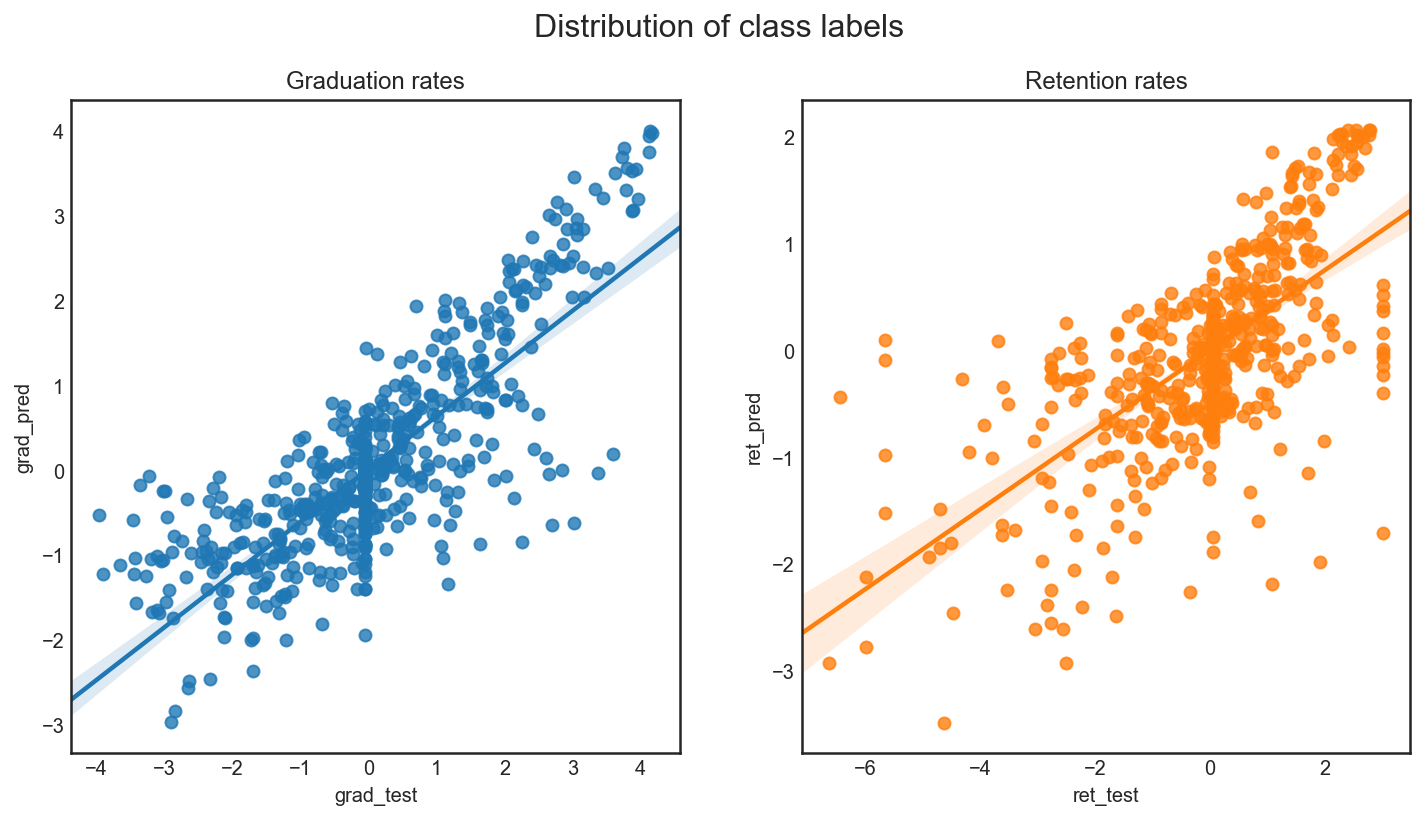

In [92]:
f,(ax1, ax2) = plt.subplots(1, 2 , figsize=(12, 6))
f.suptitle("Distribution of class labels", fontsize=16)
ax1.title.set_text('Graduation rates')
ax2.title.set_text('Retention rates')
sns.regplot(x="grad_test", y="grad_pred", data=results, ax = ax1)
sns.regplot(x="ret_test", y="ret_pred", data=results, ax = ax2)
plt.savefig("./img/results.png");

We can conclude from this visual that distribution of retention rates was the reason why we could not increase the score for it.

Now let us see the features importances of final model to see which factors affect the graduation and retention rates:

<a id='grad'></a>
### 9.2. Graduation rates

In [93]:
indices = np.argsort(features_grad)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], features_grad[indices[f]]))

Feature ranking:
1. feature 78 (87.000000)
2. feature 67 (45.000000)
3. feature 73 (42.000000)
4. feature 76 (41.000000)
5. feature 57 (41.000000)
6. feature 70 (33.000000)
7. feature 71 (31.000000)
8. feature 17 (30.000000)
9. feature 72 (29.000000)
10. feature 65 (24.000000)
11. feature 66 (23.000000)
12. feature 54 (23.000000)
13. feature 61 (23.000000)
14. feature 75 (21.000000)
15. feature 90 (21.000000)
16. feature 52 (20.000000)
17. feature 60 (20.000000)
18. feature 59 (19.000000)
19. feature 58 (18.000000)
20. feature 62 (17.000000)
21. feature 33 (16.000000)
22. feature 11 (15.000000)
23. feature 22 (14.000000)
24. feature 47 (13.000000)
25. feature 74 (13.000000)
26. feature 53 (12.000000)
27. feature 82 (12.000000)
28. feature 89 (12.000000)
29. feature 40 (11.000000)
30. feature 42 (11.000000)
31. feature 64 (11.000000)
32. feature 12 (11.000000)
33. feature 24 (10.000000)
34. feature 63 (9.000000)
35. feature 13 (8.000000)
36. feature 41 (8.000000)
37. feature 45 (8.00000

Now let us take top 10 features obtained from the importances list, i.e., indices 78, 67, 73, 76, 57, 70, 71, 17, 72, 65. 

In [94]:
features.columns[[78, 67, 73, 76, 57, 70, 71, 17, 72, 65]]

Index(['3_yr_repayment_suppressed.overall', 'part_time_share',
       'share_25_older', 'median_debt_suppressed.completers.overall', 'size',
       'avg_net_price.private', 'pell_grant_rate',
       'sat_scores.average.overall', 'federal_loan_rate',
       'demographics.race_ethnicity.non_resident_alien'],
      dtype='object')

<a id='ret'></a>
### 9.3. Retention rates

In [95]:
indices = np.argsort(features_ret)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], features_ret[indices[f]]))

Feature ranking:
1. feature 78 (52.000000)
2. feature 76 (39.000000)
3. feature 57 (36.000000)
4. feature 73 (33.000000)
5. feature 70 (27.000000)
6. feature 54 (25.000000)
7. feature 71 (23.000000)
8. feature 65 (22.000000)
9. feature 17 (21.000000)
10. feature 61 (18.000000)
11. feature 74 (18.000000)
12. feature 82 (16.000000)
13. feature 62 (16.000000)
14. feature 53 (15.000000)
15. feature 66 (14.000000)
16. feature 58 (14.000000)
17. feature 90 (14.000000)
18. feature 67 (13.000000)
19. feature 11 (11.000000)
20. feature 14 (11.000000)
21. feature 47 (11.000000)
22. feature 59 (10.000000)
23. feature 24 (10.000000)
24. feature 64 (9.000000)
25. feature 33 (8.000000)
26. feature 52 (8.000000)
27. feature 91 (8.000000)
28. feature 60 (8.000000)
29. feature 40 (7.000000)
30. feature 72 (7.000000)
31. feature 75 (7.000000)
32. feature 45 (6.000000)
33. feature 56 (5.000000)
34. feature 46 (5.000000)
35. feature 32 (5.000000)
36. feature 15 (4.000000)
37. feature 31 (4.000000)
38. fea

Now let us take top 10 features obtained from the importances list, i.e., indices 78, 76, 57, 73, 70, 54, 71, 65, 17, 61.

In [96]:
features.columns[[78, 76, 57, 73, 70, 54, 71, 65, 17, 61]]

Index(['3_yr_repayment_suppressed.overall',
       'median_debt_suppressed.completers.overall', 'size', 'share_25_older',
       'avg_net_price.private', 'program_percentage.business_marketing',
       'pell_grant_rate', 'demographics.race_ethnicity.non_resident_alien',
       'sat_scores.average.overall', 'demographics.race_ethnicity.asian'],
      dtype='object')

We can see that many features are common for both targets. Let us see how many of them are there:

In [97]:
grad_index=[78, 76, 57, 73, 70, 54, 71, 65, 17, 61]
ret_index=[78, 67, 73, 76, 57, 70, 71, 17, 72, 65]

# common features among top 10 features for graduation and retention rates
common_f = features.columns[list(set(grad_index) & set(ret_index))]

In [98]:
common_f

Index(['demographics.race_ethnicity.non_resident_alien',
       'avg_net_price.private', 'pell_grant_rate', 'share_25_older',
       'median_debt_suppressed.completers.overall',
       '3_yr_repayment_suppressed.overall', 'sat_scores.average.overall',
       'size'],
      dtype='object')

In [99]:
len(common_f)

8

8 out of 10 features are nearly equally important for predicting both targets. This makes our analysis easier, because now we don't need to do two different analysis for graduation and retention rates.

Now let us study the common features affecting them. These are:

- `demographics.race_ethnicity.non_resident_alien`

This is the total share of enrollment of undergraduate degree-seeking students who are non-resident aliens. A non-residential alien for tax purposes is a person who is not a U.S. citizen and who does not meet either the "green card" or the "substantial presence" test as described in IRS Publication 519, U.S. Tax Guide for Aliens<sup>[2]</sup>.

This is not a direct university level factor because non-US students may have problem continuing education due to tax issues or problems in getting U.S. citizenship for their education term.


- `avg_net_price.private`

This is the average net price for Title IV institutions. Title IV is a term that refers to federal financial aid funds. Federal regulations state that any federal funds disbursed to a student's account in excess of allowable charges must be delivered to the student (or parent in case of an undergraduate PLUS loan)<sup>[3]</sup>.

This can be considered as an important criteria. If students are unable to receive financial aids timely, then they may end up leaving college. High price makes it difficult for students with low econmical status to eventually drop out of college.

- `pell_grant_rate`

This is the percentage of undergraduates who received a Pell Grant. A Pell Grant is a subsidy the U.S. federal government provides for students who need it to pay for college. Federal Pell Grants are limited to students with financial need, who have not earned their first bachelor's degree, or who are enrolled in certain post-baccalaureate programs, through participating institutions<sup>[4]</sup>.

Let us see the relationship between target variables and `pell_grant_rate`:

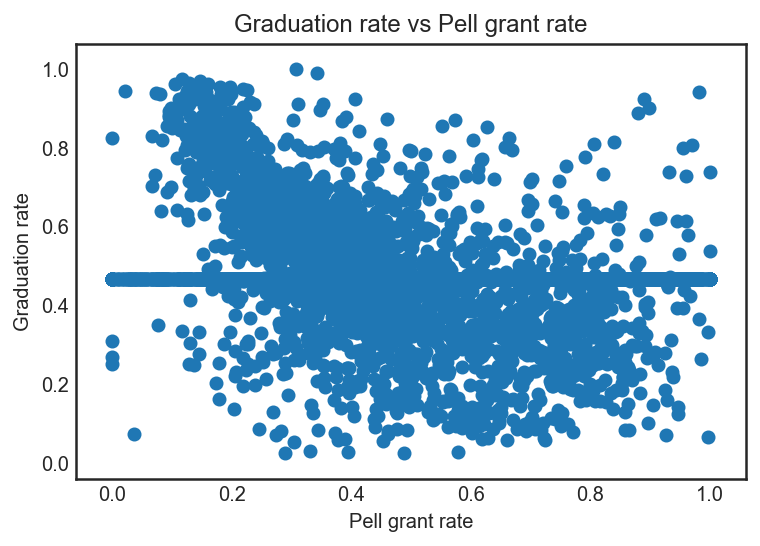

In [100]:
# df.columns[-20:]
plt.scatter(x="pell_grant_rate",
            y="rate_suppressed.four_year",
           data=df)
plt.xlabel("Pell grant rate")
plt.ylabel("Graduation rate")
plt.title("Graduation rate vs Pell grant rate")
plt.savefig("./img/grad_pell.png");

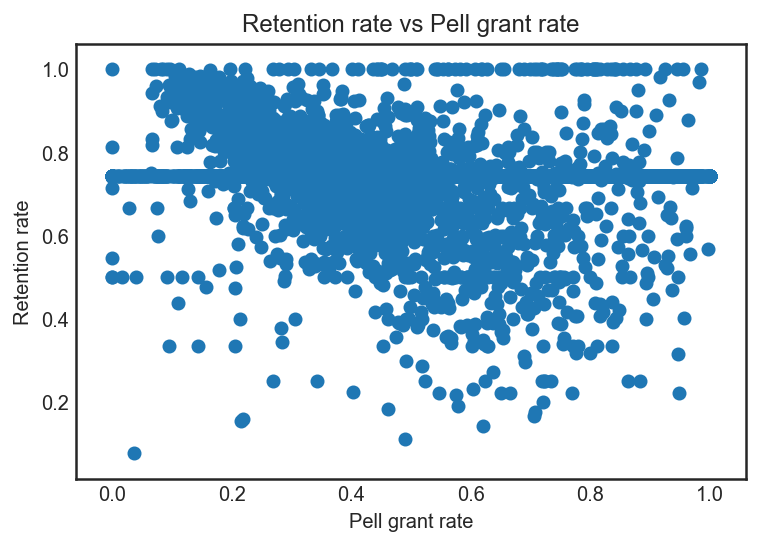

In [101]:
plt.scatter(x="pell_grant_rate",
            y="retention_rate.four_year.full_time",
           data=df)
plt.xlabel("Pell grant rate")
plt.ylabel("Retention rate")
plt.title("Retention rate vs Pell grant rate")
plt.savefig("./img/ret_pell.png");

Significant conclusion cannot be made from these plots, but we can get an idea that funding has an effect on students college life. Students who are unable to pay for education end up leaving leaving college is they do not have enough funds(Pell grant) to continue their studies.

- `share_25_older`

This is the percentage of undergraduates older than 25. Generally undergraduate are aged between 18 and 21 years. If they are above 25, then they may have have backlogs in many courses and they are not able to clear it. As a result, they decide to drop college.

- `median_debt_suppressed.completers.overall`

This is the median debt of completed of completers. Let us see what is the relation between targets and `median_debt_suppressed.completers.overall`.

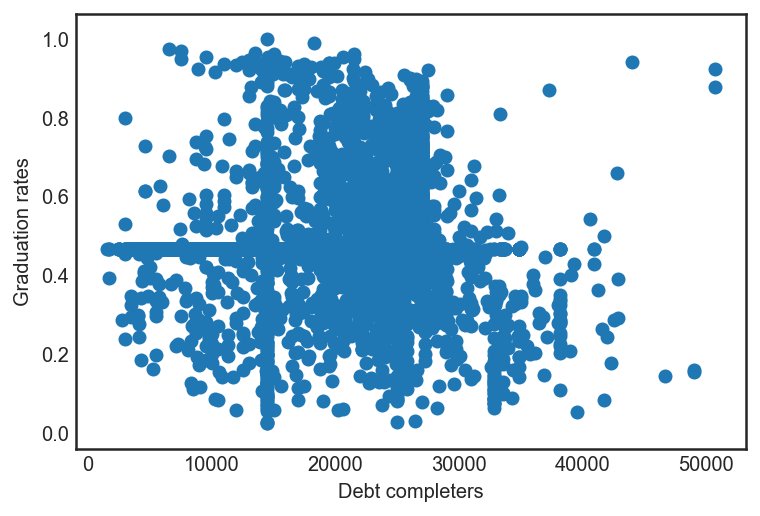

In [102]:
plt.scatter(x="median_debt_suppressed.completers.overall",
           y="rate_suppressed.four_year",
           data=df)
plt.xlabel("Debt completers")
plt.ylabel("Graduation rates")
plt.savefig("./img/grad_debt.png");

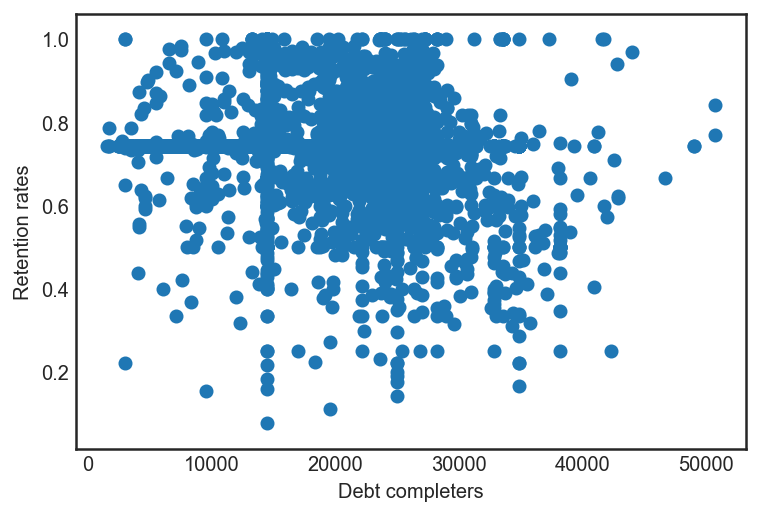

In [103]:
plt.scatter(x="median_debt_suppressed.completers.overall",
           y="retention_rate.four_year.full_time",
           data=df)
plt.xlabel("Debt completers")
plt.ylabel("Retention rates")
plt.savefig("./img/ret_debt.png");

No sufficient conclusion can be made from scatterplots for this feature.

- `3_yr_repayment_suppressed.overall`

Repayment rate depicts the fraction of borrowers at an institution who are not in default on their federal loans and who are making progress in paying them down.

Students who are not able to pay loans do not continue in next fiscal year. This reflects the economic condition of student and there ability to continue study.

- `sat_scores.average.overall`

Low academic performance is the major cause why students drop out of colleges. SAT scores is one of them. Let us see the relationship between SAT scores and and targets.

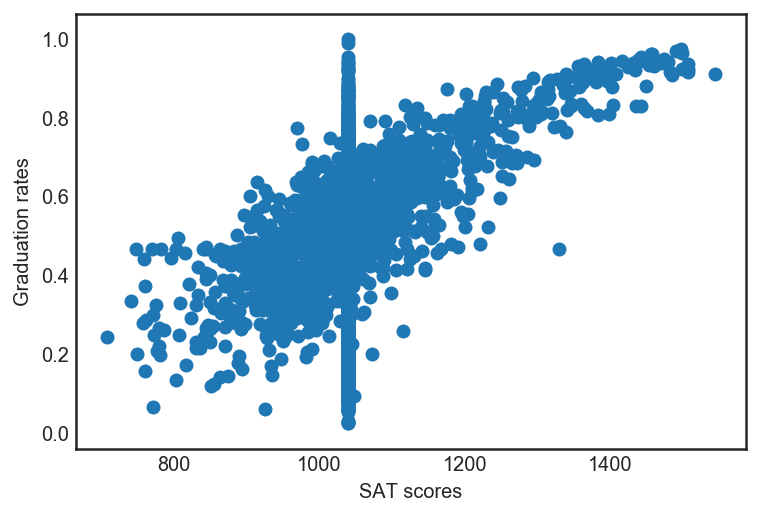

In [104]:
plt.scatter(x="sat_scores.average.overall",
           y="rate_suppressed.four_year",
           data=df)
plt.xlabel("SAT scores")
plt.ylabel("Graduation rates")
plt.savefig("./img/grad_sat.png");

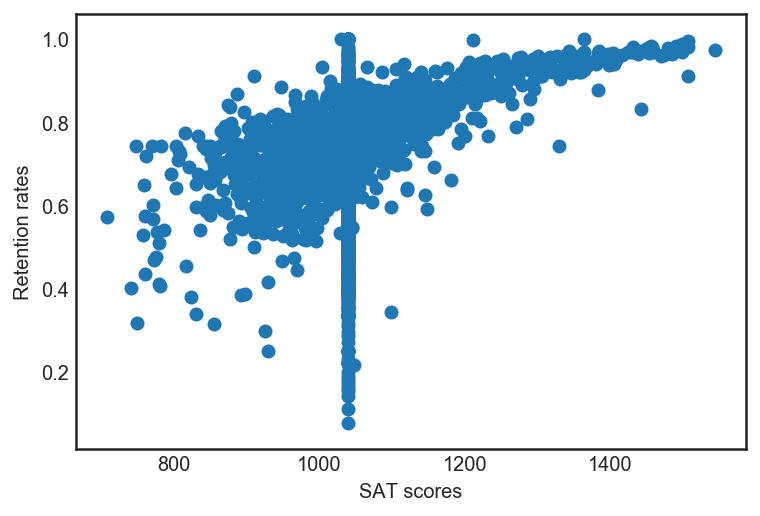

In [105]:
plt.scatter(x="sat_scores.average.overall",
           y="retention_rate.four_year.full_time",
           data=df)
plt.xlabel("SAT scores")
plt.ylabel("Retention rates")
plt.savefig("./img/ret_sat.png");

Strong correlation with SAT scores. Obviously, students who get good grades will continue to study further. Strong correlation shows how important academics are.

- `size`

Size is the number of undergraduate certificate/degree-seeking students. This is an important factor shown by our model. Size of an insitution is not a factor that should/can be modified for improving education status. More size implies more graduates. Same is the case for dropouts.

<a id='conclusion'></a>
## 10. Conclusion

If we try to categorise important factors then they are mainly demographic, financial and academic criteria. Economic criteria is more stressed out in this model.

<a id='refs'></a>
## 11. References

1. https://www.collegefactual.com/colleges/united-states-university/academic-life/graduation-and-retention/

2. http://international.umw.edu/international-services/resources-for-living-in-the-u-s/immigration-and-tax-law-definitions/resident-of-nonresident-for-tax-purposes/

3. https://studentaccounts.nd.edu/policies-procedures/federal-title-iv-funds-policy/

4. https://en.wikipedia.org/wiki/Pell_Grant